In [13]:
%matplotlib inline


In [14]:
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')


In [ ]:
import urllib.request
import tarfile

# Download the file
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
file_path = "VOCtrainval_11-May-2012.tar"
urllib.request.urlretrieve(url, file_path)

# Extract the file
with tarfile.open(file_path) as tar:
    tar.extractall()
    print("Extraction complete.")


In [ ]:
# Step 2: Install YOLOv8 and Dependencies
%pip install -q ultralytics




Note: you may need to restart the kernel to use updated packages.


In [16]:
import os
import random
from PIL import Image
import shutil

# Define dataset root
original_dataset_path = 'VOCdevkit/VOC2012'
yolo_dataset_path = './yolo_dataset'  # Update to Colab-specific path
 

In [17]:
# Create directories for YOLO format
yolo_dirs = [
    os.path.join(yolo_dataset_path, 'images', 'train'),
    os.path.join(yolo_dataset_path, 'images', 'val'),
    os.path.join(yolo_dataset_path, 'labels', 'train'),
    os.path.join(yolo_dataset_path, 'labels', 'val')
]

In [18]:
for yolo_dir in yolo_dirs:
    os.makedirs(yolo_dir, exist_ok=True)

In [19]:
# Step 4: Set Up Image and Annotation Paths
jpeg_images_dir = os.path.join(original_dataset_path, 'JPEGImages')
annotations_dir = os.path.join(original_dataset_path, 'Annotations')

In [20]:
# Ensure directories exist
if not os.path.exists(jpeg_images_dir) or not os.path.exists(annotations_dir):
    raise FileNotFoundError(f"The directory {jpeg_images_dir} or {annotations_dir} does not exist. Please verify the dataset path.")


In [21]:
image_filenames = os.listdir(jpeg_images_dir)
image_ids = [os.path.splitext(filename)[0] for filename in image_filenames if filename.endswith('.jpg')]

#Split the dataset into train and validation sets

In [22]:

random.seed(42)
random.shuffle(image_ids)
split_index = int(0.8 * len(image_ids))  # 80% for training, 20% for validation
train_ids = image_ids[:split_index]
val_ids = image_ids[split_index:]

 #Convert PASCAL VOC Annotations to YOLO Format

In [12]:
import xml.etree.ElementTree as ET

# Define the function to convert Pascal VOC XML to YOLO annotation format
def create_yolo_annotation(xml_file_path, yolo_label_path, label_dict):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    annotations = []  # List to store YOLO annotations

    img_width = int(root.find('size/width').text)
    img_height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        label = obj.find('name').text
        if label not in label_dict:
            continue
        label_idx = label_dict[label]
        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)

        # YOLO annotation format: label x_center y_center width height (normalized)
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        annotations.append(f"{label_idx} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    # Save annotations to the label file
    with open(yolo_label_path, 'w') as f:
        f.write("\n".join(annotations))

# Define label dictionary for Pascal VOC
label_dict = {
    'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4,
    'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9,
    'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14,
    'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19
}

# Loop through images and annotations to prepare dataset for YOLO format
for image_set, ids in [('train', train_ids), ('val', val_ids)]:
    for img_id in ids:
        img_src_path = os.path.join(jpeg_images_dir, f'{img_id}.jpg')
        label_dst_path = os.path.join(yolo_dataset_path, 'labels', image_set, f'{img_id}.txt')

        # Create the YOLO annotation file
        xml_file_path = os.path.join(annotations_dir, f'{img_id}.xml')
        if not os.path.exists(xml_file_path):
            print(f"Warning: Annotation {xml_file_path} not found, skipping.")
            continue
        create_yolo_annotation(xml_file_path, label_dst_path, label_dict)

        # Copy the image to the new YOLO dataset structure
        img_dst_path = os.path.join(yolo_dataset_path, 'images', image_set, f'{img_id}.jpg')
        shutil.copy(img_src_path, img_dst_path)


Medium

In [8]:
from ultralytics import YOLO
import os

# Load YOLOv8 model
yolo8m_model = YOLO('yolov8m.pt')  # YOLOv8 medium model

# Resume training with optimizations
yolo8m_model.train(
    data=os.path.join(yolo_dataset_path, 'data.yaml'),  # Dataset configuration
    epochs=100,                                         # Reduce epochs for faster convergence
    imgsz=416,                                         # Smaller image size for speed
    batch=32,                                           # Smaller batch size
    optimizer='AdamW',                                   # Faster optimizer with higher initial LR
    lr0=0.01,                                          # Increased initial learning rate
    lrf=0.2,                                           # Final learning rate fraction
    weight_decay=0.0005,                               # Regularization (consider 0.01)
    amp=True,                                          # Enable mixed precision
    pretrained=True,                                   # Use pretrained weights
    augment=False,                                     # Disable heavy augmentations
    workers=2,                                         # Fewer workers for data loading
    freeze=10,                                         # Freeze early layers for speed
    name='yolov8m_custom',                             # Custom model name
    save=True,                                         # Save the best model
    save_period=5                                      # Save model every 5 epochs
)

New https://pypi.org/project/ultralytics/8.3.34 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.28  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=./yolo_dataset\data.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=5, cache=False, device=None, workers=2, project=None, name=yolov8m_custom8, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, s

train: Scanning D:\Dhruv\Minor ODS\yolo_dataset\labels\train.cache... 13700 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13700/13700 [00:00<?, ?it/s]
val: Scanning D:\Dhruv\Minor ODS\yolo_dataset\labels\val.cache... 3425 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3425/3425 [00:00<?, ?it/s]


Plotting labels to runs\detect\yolov8m_custom8\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs\detect\yolov8m_custom8
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.45G      1.262      1.691      1.414         33        416: 100%|██████████| 429/429 [05:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.19it/s]


                   all       3425       7789      0.449      0.496      0.454      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.51G      1.219      1.466      1.405         23        416: 100%|██████████| 429/429 [03:52<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:15<00:00,  1.40s/it]


                   all       3425       7789      0.618      0.562      0.584      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.56G      1.138       1.34      1.359         21        416: 100%|██████████| 429/429 [03:40<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:03<00:00,  1.18s/it]


                   all       3425       7789      0.637      0.612      0.636      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.55G      1.104       1.28      1.341         26        416: 100%|██████████| 429/429 [05:52<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:30<00:00,  1.67s/it]


                   all       3425       7789      0.653      0.634       0.66      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.51G      1.051      1.209      1.307         23        416: 100%|██████████| 429/429 [05:53<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:06<00:00,  1.23s/it]


                   all       3425       7789      0.699      0.641      0.691      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.54G      1.013      1.158      1.283         15        416: 100%|██████████| 429/429 [05:50<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:30<00:00,  1.68s/it]


                   all       3425       7789      0.688      0.674      0.704      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.48G     0.9929      1.124      1.273         15        416: 100%|██████████| 429/429 [05:17<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:56<00:00,  1.04s/it]


                   all       3425       7789      0.713      0.678      0.722      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.47G     0.9674      1.091      1.259         12        416: 100%|██████████| 429/429 [05:31<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:46<00:00,  1.97s/it]


                   all       3425       7789      0.747      0.663      0.728       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.48G     0.9494      1.065      1.248         11        416: 100%|██████████| 429/429 [05:58<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:06<00:00,  1.24s/it]


                   all       3425       7789      0.716       0.68      0.729      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.54G     0.9339      1.049      1.241         22        416: 100%|██████████| 429/429 [05:45<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:35<00:00,  1.78s/it]


                   all       3425       7789      0.733      0.686      0.736      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.55G      0.934      1.036      1.239         19        416: 100%|██████████| 429/429 [05:57<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:07<00:00,  1.24s/it]


                   all       3425       7789      0.748      0.672       0.73      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.54G     0.9174       1.01      1.229         25        416: 100%|██████████| 429/429 [05:57<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:26<00:00,  1.60s/it]


                   all       3425       7789      0.729      0.687       0.74       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.57G     0.9083      1.001      1.217         25        416: 100%|██████████| 429/429 [05:57<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:09<00:00,  1.29s/it]


                   all       3425       7789      0.723      0.691      0.743      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.54G     0.8944     0.9813       1.21         26        416: 100%|██████████| 429/429 [05:58<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:34<00:00,  1.74s/it]


                   all       3425       7789      0.734      0.704      0.744      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.48G     0.8885     0.9733      1.208         28        416: 100%|██████████| 429/429 [05:59<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:07<00:00,  1.26s/it]


                   all       3425       7789      0.752      0.694      0.754      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.56G     0.8762     0.9533      1.202         11        416: 100%|██████████| 429/429 [05:58<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:40<00:00,  1.86s/it]


                   all       3425       7789      0.762       0.68      0.751      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.49G     0.8693     0.9455      1.194         22        416: 100%|██████████| 429/429 [05:33<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:56<00:00,  1.04s/it]

                   all       3425       7789      0.753      0.684      0.747      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.55G     0.8701     0.9447      1.195         12        416: 100%|██████████| 429/429 [05:31<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:30<00:00,  1.68s/it]

                   all       3425       7789       0.77      0.687      0.752      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.56G     0.8607     0.9262      1.188         16        416: 100%|██████████| 429/429 [05:27<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:08<00:00,  1.26s/it]


                   all       3425       7789      0.749      0.702      0.753      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.61G     0.8544     0.9238      1.183         34        416: 100%|██████████| 429/429 [05:34<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:23<00:00,  1.55s/it]

                   all       3425       7789      0.753      0.703      0.757      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.54G     0.8435     0.9136      1.178         11        416: 100%|██████████| 429/429 [05:30<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:56<00:00,  1.05s/it]

                   all       3425       7789      0.766      0.702      0.759      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.55G     0.8388     0.9074      1.175         20        416: 100%|██████████| 429/429 [04:32<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:14<00:00,  1.37s/it]

                   all       3425       7789      0.735      0.718      0.757       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.58G     0.8355     0.8938      1.173         33        416: 100%|██████████| 429/429 [03:29<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:43<00:00,  1.23it/s]

                   all       3425       7789      0.766      0.694      0.759      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.55G     0.8329     0.8929       1.17         28        416: 100%|██████████| 429/429 [03:33<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:05<00:00,  1.21s/it]

                   all       3425       7789      0.758      0.704      0.759       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.55G     0.8251     0.8784      1.164         18        416: 100%|██████████| 429/429 [03:27<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:43<00:00,  1.23it/s]

                   all       3425       7789      0.756      0.705      0.762      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.52G     0.8274     0.8771      1.163         20        416: 100%|██████████| 429/429 [03:31<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:09<00:00,  1.29s/it]

                   all       3425       7789      0.786      0.699      0.764       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.55G     0.8162     0.8621      1.155         25        416: 100%|██████████| 429/429 [03:35<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:43<00:00,  1.23it/s]

                   all       3425       7789      0.764      0.708      0.765      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.55G     0.8091     0.8536      1.153         35        416: 100%|██████████| 429/429 [04:20<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:37<00:00,  1.80s/it]


                   all       3425       7789      0.769      0.714      0.764      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.56G     0.8106     0.8527      1.152         19        416: 100%|██████████| 429/429 [05:55<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:08<00:00,  1.27s/it]


                   all       3425       7789      0.781      0.697      0.765      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.57G     0.8063     0.8499      1.151         13        416: 100%|██████████| 429/429 [05:55<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:27<00:00,  1.62s/it]

                   all       3425       7789       0.76      0.714      0.763       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.55G     0.7969     0.8377      1.144         16        416: 100%|██████████| 429/429 [05:55<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:50<00:00,  1.08it/s]

                   all       3425       7789      0.785      0.699      0.767      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.37G     0.8006     0.8359       1.14         19        416: 100%|██████████| 429/429 [05:34<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:26<00:00,  1.60s/it]


                   all       3425       7789      0.781      0.701      0.767      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.56G     0.7914     0.8311      1.141         29        416: 100%|██████████| 429/429 [05:40<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:56<00:00,  1.05s/it]

                   all       3425       7789      0.773      0.711      0.767      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.48G     0.7902     0.8228      1.137         29        416: 100%|██████████| 429/429 [05:30<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:27<00:00,  1.62s/it]

                   all       3425       7789      0.783      0.696      0.767      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.57G     0.7868     0.8225      1.134         24        416: 100%|██████████| 429/429 [05:13<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:04<00:00,  1.19s/it]

                   all       3425       7789      0.771      0.704      0.764      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.53G     0.7829     0.8098      1.131         14        416: 100%|██████████| 429/429 [05:50<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:07<00:00,  1.25s/it]

                   all       3425       7789      0.768      0.708      0.766      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.54G     0.7783     0.8016      1.131         21        416: 100%|██████████| 429/429 [05:35<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:56<00:00,  1.04s/it]

                   all       3425       7789      0.784      0.701      0.766      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.55G     0.7705     0.8004      1.123         21        416: 100%|██████████| 429/429 [05:31<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:22<00:00,  1.53s/it]

                   all       3425       7789      0.773      0.707      0.767        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       2.5G     0.7768     0.7911      1.127         18        416: 100%|██████████| 429/429 [05:31<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:56<00:00,  1.05s/it]

                   all       3425       7789      0.768      0.701      0.763      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.57G     0.7682     0.7932      1.122         18        416: 100%|██████████| 429/429 [05:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:28<00:00,  1.63s/it]

                   all       3425       7789      0.767      0.703      0.764      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       2.5G     0.7624     0.7852      1.115         13        416: 100%|██████████| 429/429 [05:31<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:56<00:00,  1.04s/it]

                   all       3425       7789       0.79      0.693      0.767      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.54G     0.7691     0.7815       1.12         19        416: 100%|██████████| 429/429 [05:24<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:09<00:00,  1.28s/it]

                   all       3425       7789      0.776      0.698      0.764      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.46G     0.7576     0.7775      1.117         20        416: 100%|██████████| 429/429 [05:11<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:44<00:00,  1.22it/s]

                   all       3425       7789      0.776        0.7      0.764      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       2.5G     0.7622     0.7717      1.113         15        416: 100%|██████████| 429/429 [05:05<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:11<00:00,  1.32s/it]

                   all       3425       7789      0.782      0.699      0.767      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.54G     0.7569     0.7719      1.115         18        416: 100%|██████████| 429/429 [05:30<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:55<00:00,  1.03s/it]

                   all       3425       7789      0.771      0.712      0.765        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.53G     0.7551     0.7668      1.112         13        416: 100%|██████████| 429/429 [05:30<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:16<00:00,  1.42s/it]

                   all       3425       7789      0.771      0.713      0.765        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.49G     0.7436     0.7609      1.106         19        416: 100%|██████████| 429/429 [05:30<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:56<00:00,  1.04s/it]

                   all       3425       7789      0.776      0.707      0.763      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.45G     0.7482     0.7605       1.11         32        416: 100%|██████████| 429/429 [05:13<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:15<00:00,  1.40s/it]

                   all       3425       7789      0.768      0.711      0.763        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.48G     0.7459     0.7523      1.106         20        416: 100%|██████████| 429/429 [05:31<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:57<00:00,  1.07s/it]

                   all       3425       7789      0.764      0.715      0.763      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.42G     0.7431     0.7489      1.106         17        416: 100%|██████████| 429/429 [05:31<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:18<00:00,  1.45s/it]

                   all       3425       7789      0.768      0.709      0.765      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.63G     0.7401     0.7433      1.099         25        416: 100%|██████████| 429/429 [05:28<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:06<00:00,  1.24s/it]

                   all       3425       7789      0.772      0.706      0.765        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.54G     0.7402      0.742        1.1         17        416: 100%|██████████| 429/429 [05:53<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:28<00:00,  1.64s/it]

                   all       3425       7789      0.772      0.707      0.766        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.54G     0.7385     0.7438        1.1         16        416: 100%|██████████| 429/429 [05:16<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:05<00:00,  1.22s/it]

                   all       3425       7789      0.776      0.704      0.766      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.54G     0.7361     0.7352      1.098         35        416: 100%|██████████| 429/429 [05:55<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:33<00:00,  1.73s/it]

                   all       3425       7789      0.786      0.696      0.766        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.48G     0.7337     0.7317      1.097         20        416: 100%|██████████| 429/429 [05:57<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:07<00:00,  1.26s/it]

                   all       3425       7789      0.771       0.71      0.765      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.52G     0.7275     0.7253      1.092         15        416: 100%|██████████| 429/429 [05:26<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:09<00:00,  1.28s/it]

                   all       3425       7789      0.772       0.71      0.766      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.55G      0.727     0.7278      1.097         23        416: 100%|██████████| 429/429 [03:57<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.19it/s]

                   all       3425       7789       0.76       0.72      0.766      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.54G     0.7229     0.7147      1.088         16        416: 100%|██████████| 429/429 [04:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:04<00:00,  1.19s/it]

                   all       3425       7789      0.755      0.722      0.765      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.48G      0.725     0.7096      1.087         17        416: 100%|██████████| 429/429 [03:57<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.20it/s]

                   all       3425       7789      0.765      0.718      0.765      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.54G      0.722     0.7131      1.091         10        416: 100%|██████████| 429/429 [03:57<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:03<00:00,  1.18s/it]

                   all       3425       7789      0.774      0.707      0.763      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.54G     0.7196     0.7138      1.086         19        416: 100%|██████████| 429/429 [03:59<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:44<00:00,  1.20it/s]

                   all       3425       7789      0.768      0.711      0.763      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.52G     0.7236     0.7087       1.09         20        416: 100%|██████████| 429/429 [04:00<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:04<00:00,  1.20s/it]

                   all       3425       7789      0.776      0.704      0.762      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.53G      0.713     0.6985      1.084         23        416: 100%|██████████| 429/429 [04:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.20it/s]

                   all       3425       7789      0.777      0.704      0.762      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.52G      0.711     0.6983      1.082         18        416: 100%|██████████| 429/429 [03:59<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:04<00:00,  1.19s/it]

                   all       3425       7789      0.765      0.711      0.762      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.55G     0.7117      0.696      1.082         27        416: 100%|██████████| 429/429 [04:04<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.19it/s]

                   all       3425       7789      0.774      0.705      0.762      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.54G     0.7104     0.6949      1.079         23        416: 100%|██████████| 429/429 [03:58<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:08<00:00,  1.27s/it]

                   all       3425       7789      0.778      0.706      0.763        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.54G     0.7125     0.6927      1.081         20        416: 100%|██████████| 429/429 [04:02<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.19it/s]

                   all       3425       7789      0.782      0.702      0.763      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.54G     0.7059     0.6852      1.078         16        416: 100%|██████████| 429/429 [04:00<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:06<00:00,  1.23s/it]

                   all       3425       7789      0.776      0.704      0.763        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.56G     0.7071     0.6871       1.08          7        416: 100%|██████████| 429/429 [03:57<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.20it/s]

                   all       3425       7789       0.77      0.709      0.763        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.54G     0.7072     0.6876      1.078         23        416: 100%|██████████| 429/429 [03:58<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:05<00:00,  1.21s/it]

                   all       3425       7789      0.763      0.714      0.763        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       2.5G     0.6987      0.675      1.071         22        416: 100%|██████████| 429/429 [03:55<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.19it/s]

                   all       3425       7789      0.765      0.709      0.762        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.51G     0.6985     0.6758      1.073         11        416: 100%|██████████| 429/429 [04:02<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:03<00:00,  1.18s/it]

                   all       3425       7789      0.774      0.704      0.762      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.55G     0.6987     0.6735       1.07         11        416: 100%|██████████| 429/429 [04:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.20it/s]

                   all       3425       7789       0.77      0.707      0.762        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.53G     0.6926     0.6717       1.07         27        416: 100%|██████████| 429/429 [04:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:12<00:00,  1.34s/it]

                   all       3425       7789      0.774      0.703      0.761        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.54G     0.6925     0.6658      1.067         13        416: 100%|██████████| 429/429 [04:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.19it/s]

                   all       3425       7789      0.771      0.706      0.762        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.57G     0.6932      0.665      1.071         24        416: 100%|██████████| 429/429 [04:02<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:06<00:00,  1.23s/it]

                   all       3425       7789      0.777      0.701      0.762        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.56G     0.6915     0.6588      1.068         10        416: 100%|██████████| 429/429 [03:59<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.19it/s]

                   all       3425       7789      0.776      0.702      0.762        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.45G     0.6869     0.6598      1.065         17        416: 100%|██████████| 429/429 [03:58<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:10<00:00,  1.30s/it]

                   all       3425       7789      0.784      0.697      0.762        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.54G     0.6889     0.6533      1.064         11        416: 100%|██████████| 429/429 [03:55<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.19it/s]

                   all       3425       7789      0.786      0.696      0.763        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.52G     0.6817      0.651      1.061          4        416: 100%|██████████| 429/429 [03:56<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:14<00:00,  1.38s/it]

                   all       3425       7789      0.782      0.698      0.762        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.46G     0.6878     0.6523      1.061          9        416: 100%|██████████| 429/429 [03:58<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.19it/s]

                   all       3425       7789      0.782      0.699      0.762        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.53G     0.6808     0.6468      1.061         15        416: 100%|██████████| 429/429 [03:59<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:19<00:00,  1.46s/it]

                   all       3425       7789       0.78        0.7      0.762        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.54G     0.6813     0.6508      1.061         40        416: 100%|██████████| 429/429 [03:57<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.20it/s]

                   all       3425       7789      0.781        0.7      0.761        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.41G     0.6773     0.6456      1.058          9        416: 100%|██████████| 429/429 [04:01<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:02<00:00,  1.17s/it]

                   all       3425       7789       0.78      0.699      0.761      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.48G      0.673     0.6335      1.056         37        416: 100%|██████████| 429/429 [03:58<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.19it/s]

                   all       3425       7789      0.777      0.703      0.761      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.48G      0.679     0.6367      1.056         24        416: 100%|██████████| 429/429 [04:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:07<00:00,  1.25s/it]

                   all       3425       7789      0.777      0.702      0.761      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.55G     0.6738     0.6371      1.057         23        416: 100%|██████████| 429/429 [03:57<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.20it/s]

                   all       3425       7789       0.78      0.701      0.761        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.53G     0.6732     0.6372      1.054         24        416: 100%|██████████| 429/429 [03:53<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:03<00:00,  1.18s/it]

                   all       3425       7789      0.781      0.701      0.761        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.48G      0.664      0.625      1.049         21        416: 100%|██████████| 429/429 [03:57<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.19it/s]

                   all       3425       7789      0.786      0.697       0.76        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.56G     0.6704     0.6261      1.053         15        416: 100%|██████████| 429/429 [03:54<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:04<00:00,  1.19s/it]

                   all       3425       7789      0.781      0.702       0.76        0.6


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.54G     0.5958     0.4686     0.9716          5        416: 100%|██████████| 429/429 [03:59<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.18it/s]

                   all       3425       7789      0.779      0.702       0.76        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.54G      0.587     0.4566     0.9644         10        416: 100%|██████████| 429/429 [33:47<00:00,  4.73s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:10<00:00,  1.31s/it]

                   all       3425       7789      0.776      0.704       0.76        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.47G     0.5874     0.4525      0.965         12        416: 100%|██████████| 429/429 [03:55<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.19it/s]

                   all       3425       7789      0.773      0.703       0.76        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.41G     0.5768     0.4405     0.9579          6        416: 100%|██████████| 429/429 [03:54<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:15<00:00,  1.39s/it]

                   all       3425       7789      0.773      0.702       0.76        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.54G     0.5736     0.4369     0.9559         14        416: 100%|██████████| 429/429 [03:54<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.20it/s]

                   all       3425       7789      0.774      0.702       0.76      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.55G     0.5744     0.4338     0.9571         10        416: 100%|██████████| 429/429 [03:52<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:03<00:00,  1.19s/it]

                   all       3425       7789      0.791      0.688       0.76        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.46G     0.5714     0.4299     0.9567          7        416: 100%|██████████| 429/429 [03:54<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:44<00:00,  1.20it/s]

                   all       3425       7789      0.788      0.691       0.76        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.53G      0.566     0.4171     0.9535          7        416: 100%|██████████| 429/429 [03:52<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:02<00:00,  1.16s/it]

                   all       3425       7789      0.774      0.704       0.76        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.47G     0.5632     0.4159     0.9511          7        416: 100%|██████████| 429/429 [03:55<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:44<00:00,  1.21it/s]

                   all       3425       7789       0.77      0.705       0.76        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       2.4G     0.5603     0.4119     0.9482         16        416: 100%|██████████| 429/429 [03:50<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:02<00:00,  1.15s/it]

                   all       3425       7789      0.774      0.703       0.76      0.599



100 epochs completed in 10.209 hours.
Optimizer stripped from runs\detect\yolov8m_custom8\weights\last.pt, 52.0MB
Optimizer stripped from runs\detect\yolov8m_custom8\weights\best.pt, 52.0MB

Validating runs\detect\yolov8m_custom8\weights\best.pt...
Ultralytics 8.3.28  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 218 layers, 25,851,340 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.18it/s]


                   all       3425       7789      0.782      0.698      0.767      0.601
             aeroplane        140        195        0.9      0.846      0.886      0.729
               bicycle        117        150      0.653      0.653      0.709      0.563
                  bird        175        269      0.898       0.77      0.836      0.629
                  boat        126        255      0.738      0.545      0.627      0.381
                bottle        170        278      0.717      0.474       0.59      0.414
                   bus         92        130      0.865      0.815      0.879      0.776
                   car        264        506      0.748      0.634      0.719      0.542
                   cat        219        243      0.897      0.918      0.948      0.833
                 chair        243        509      0.686      0.495      0.577      0.432
                   cow         69        155      0.866      0.832      0.897      0.658
           diningtabl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001B0B7CCC0E0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0

In [9]:
# Save the trained YOLOv8 model
model_path = './yolov8m_custmodel.pt'
yolo8m_model.save(model_path)


In [23]:
from ultralytics import YOLO

# Load the saved YOLOv8 model
yolo8m_model = YOLO('yolov8m_custmodel.pt')

In [ ]:
metrics2 = yolo8m_model.val(
    data=os.path.join(yolo_dataset_path, 'data.yaml'),
    batch=32,
    imgsz=416,
    conf=0.3,  # Lower confidence threshold
    iou=0.5
)

# Print out metrics
print("Evaluation Metrics:")
print(f"Precision: {metrics2.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall: {metrics2.results_dict['metrics/recall(B)']:.4f}")
# print(f"F1 Score: {metrics.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5: {metrics2.results_dict['metrics/mAP50(B)']:.4f}")  # mAP at IoU threshold of 0.5
print(f"mAP@0.5:0.95: {metrics2.results_dict['metrics/mAP50-95(B)']:.4f}")  # mAP averaged over IoU thresholds from 0.5 to 0.95
print(f"fitness: {metrics2.results_dict['fitness']:.4f}")

Ultralytics 8.3.28  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 218 layers, 25,851,340 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning D:\Dhruv\Minor ODS\yolo_dataset\labels\val.cache... 3425 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3425/3425 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [01:26<00:00,  1.25it/s]


                   all       3425       7789      0.787        0.7      0.778       0.65
             aeroplane        140        195      0.923      0.841      0.908      0.795
               bicycle        117        150      0.656      0.653       0.71      0.594
                  bird        175        269      0.906      0.758      0.853       0.69
                  boat        126        255      0.749      0.545       0.67      0.452
                bottle        170        278      0.734      0.482      0.628      0.494
                   bus         92        130      0.853      0.815      0.884      0.822
                   car        264        506      0.751      0.637      0.736      0.602
                   cat        219        243      0.906      0.916       0.94      0.848
                 chair        243        509      0.686      0.499      0.611        0.5
                   cow         69        155       0.87      0.832      0.896      0.711
           diningtabl

In [ ]:


# Set a limit for the number of images to display
display_limit = 10 # Change this to the desired number of images to show

# Run inference on validation set images with streaming enabled
results = yolo8m_model.predict('D:/Dhruv/Minor ODS/yolo_dataset/images/val', save=True, stream=True)

# Display predictions up to the specified limit
for i, result in enumerate(results):
    if i >= display_limit:
        break  # Stop once the limit is reached
    result.show()  # Display each image with predictions



image 1/3425 D:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000187.jpg: 480x640 2 tvmonitors, 198.3ms
image 2/3425 D:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000272.jpg: 640x448 1 person, 41.9ms
image 3/3425 D:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000392.jpg: 448x640 1 person, 41.1ms
image 4/3425 D:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000648.jpg: 448x640 1 aeroplane, 1 bus, 2 cars, 5 persons, 41.1ms
image 5/3425 D:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000676.jpg: 480x640 1 cow, 2 sheeps, 46.2ms
image 6/3425 D:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000727.jpg: 640x480 2 buss, 6 cars, 2 persons, 46.5ms
image 7/3425 D:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000793.jpg: 480x640 1 bicycle, 1 bus, 7 persons, 45.3ms
image 8/3425 D:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000799.jpg: 576x640 2 horses, 1 person, 55.1ms
image 9/3425 D:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_001073.jpg: 480x640 1 car, 8 cows, 1 dog, 1 sheep, 45.5ms
image 10/

In [24]:
#Predicitve System
from pathlib import Path
from ultralytics import YOLO  # Ensure YOLOv8 is installed

def predict_and_display(image_path):
    try:
        # Check if the file exists
        image_path = Path(image_path)
        if not image_path.exists():
            print(f"Error: The file {image_path} does not exist.")
            return

        # Run inference on the image
        results = yolo8m_model.predict(source=str(image_path), save=True)

        # Display the image with predictions
        for result in results:
            result.show()  # Show the image with bounding boxes and confidence scores

        print(f"Predictions completed. The output has been saved in the same directory as the input image.")
    
    except Exception as e:
        print(f"An error occurred: {e}")

# Input image path from the user
image_path_input = input("Enter the path to the image: ")
predict_and_display(image_path_input)



image 1/1 D:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000272.jpg: 640x448 1 person, 43.9ms
Speed: 2.0ms preprocess, 43.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)
Results saved to runs\detect\predict26
Predictions completed. The output has been saved in the same directory as the input image.


'D:/Dhruv/Minor ODS/yolo_dataset/images/val/2007_000272.jpg'
'D:/Dhruv/Minor ODS/yolo_dataset/images/val/2007_000187.jpg'
'D:/Dhruv/Minor ODS/yolo_dataset/images/val/2007_000392.jpg'
'D:/Dhruv/Minor ODS/yolo_dataset/images/val/2007_000648.jpg'
'D:/Dhruv/Minor ODS/yolo_dataset/images/val/2007_000727.jpg'
'D:/Dhruv/Minor ODS/yolo_dataset/images/val/2007_000793.jpg'
'D:/Dhruv/Minor ODS/yolo_dataset/images/val/2007_000799.jpg'

XAI Techniques

In [43]:
%pip install lime


Note: you may need to restart the kernel to use updated packages.


In [12]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

# YOLOv8 Wrapper Class
class YOLOv8Wrapper:
    def __init__(self, model, num_classes):
        self.model = model
        self.num_classes = num_classes  # Total number of classes in the YOLO model

    def predict(self, images):
        predictions = []
        for img in images:
            # Resize image to YOLO-compatible size
            img = Image.fromarray((img * 255).astype(np.uint8)).resize((640, 640))  # Convert back to uint8
            img_tensor = torch.tensor(np.array(img)).permute(2, 0, 1).unsqueeze(0)
            img_tensor = img_tensor.float().to('cuda' if torch.cuda.is_available() else 'cpu')
            
            # Normalize to 0-1 and predict
            img_tensor /= 255.0
            results = self.model.predict(img_tensor, imgsz=640, conf=0.25)
            
            # Initialize confidences for all classes as zeros
            confidences = np.zeros(self.num_classes)
            
            # Extract confidences from the predictions
            for box in results[0].boxes:
                class_id = int(box.cls)
                confidences[class_id] = max(confidences[class_id], box.conf.cpu().item())
            
            predictions.append(confidences)
        
        return np.array(predictions)

# Preprocess Input Image
def preprocess_image(image_path, img_size=640):
    image = Image.open(image_path).convert('RGB')
    # Resize to the required size while maintaining aspect ratio
    image = image.resize((img_size, img_size))  # YOLOv8 expects square inputs
    image_np = np.array(image) / 255.0  # Normalize to 0-1 as float32
    return image_np.astype(np.float32)

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Path to test image
test_image_path = 'yolo_dataset/images/val/2007_000272.jpg'  # Replace with an actual image path
image_np = preprocess_image(test_image_path, img_size=640)

# Target label for explanation (e.g., "dog")
num_classes = 20  # Replace with the actual number of classes in your YOLOv8 model
target_label = 14  # Replace with the index of the class you want to explain
model_wrapper = YOLOv8Wrapper(yolo8m_model, num_classes)

# Generate LIME explanation
explanation = explainer.explain_instance(
    image_np, 
    model_wrapper.predict, 
    top_labels=1, 
    hide_color=0, 
    num_samples=1000  # Number of perturbations
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    target_label, 
    positive_only=True, 
    num_features=10, 
    hide_rest=False
)

plt.figure(figsize=(8, 8))  # Adjust figure size
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.title(f"Explanation for class {target_label}")
plt.show()  # Display the plot



  0%|          | 0/1000 [00:00<?, ?it/s]


0: 640x640 1 person, 159.7ms
Speed: 1.0ms preprocess, 159.7ms inference, 16.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 58.0ms
Speed: 0.0ms preprocess, 58.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 horse, 2 persons, 57.3ms
Speed: 0.0ms preprocess, 57.3ms inference, 12.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 boat, 57.1ms
Speed: 0.0ms preprocess, 57.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 56.6ms
Speed: 0.0ms preprocess, 56.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 57.7ms
Speed: 0.0ms preprocess, 57.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 57.4ms
Speed: 0.0ms preprocess, 57.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 56.3ms
Speed: 0.0ms preprocess, 56.3ms inference, 2.9ms postprocess per image

KeyboardInterrupt: 

  0%|          | 0/1000 [00:00<?, ?it/s]


0: 640x640 1 person, 170.8ms
Speed: 0.0ms preprocess, 170.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 59.0ms
Speed: 0.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 boat, 1 person, 57.0ms
Speed: 0.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 boat, 1 person, 56.8ms
Speed: 0.0ms preprocess, 56.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 57.0ms
Speed: 0.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 57.0ms
Speed: 0.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 55.5ms
Speed: 0.0ms preprocess, 55.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 boat, 1 cow, 3 persons, 55.5ms
Speed: 0.0ms preprocess, 55.5ms inference, 3.0m

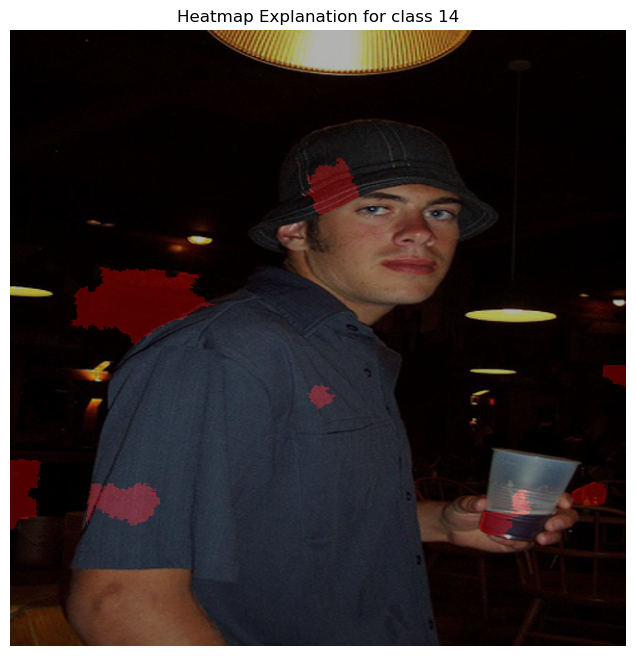

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

# YOLOv8 Wrapper Class
class YOLOv8Wrapper:
    def __init__(self, model, num_classes):
        self.model = model
        self.num_classes = num_classes  # Total number of classes in the YOLO model

    def predict(self, images):
        predictions = []
        for img in images:
            # Resize image to YOLO-compatible size
            img = Image.fromarray((img * 255).astype(np.uint8)).resize((640, 640))  # Convert back to uint8
            img_tensor = torch.tensor(np.array(img)).permute(2, 0, 1).unsqueeze(0)
            img_tensor = img_tensor.float().to('cuda' if torch.cuda.is_available() else 'cpu')
            
            # Normalize to 0-1 and predict
            img_tensor /= 255.0
            results = self.model.predict(img_tensor, imgsz=640, conf=0.25)
            
            # Initialize confidences for all classes as zeros
            confidences = np.zeros(self.num_classes)
            
            # Extract confidences from the predictions
            for box in results[0].boxes:
                class_id = int(box.cls)
                confidences[class_id] = max(confidences[class_id], box.conf.cpu().item())
            
            predictions.append(confidences)
        
        return np.array(predictions)

# Preprocess Input Image
def preprocess_image(image_path, img_size=640):
    image = Image.open(image_path).convert('RGB')
    # Resize to the required size while maintaining aspect ratio
    image = image.resize((img_size, img_size))  # YOLOv8 expects square inputs
    image_np = np.array(image) / 255.0  # Normalize to 0-1 as float32
    return image_np.astype(np.float32)

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Path to test image
test_image_path = 'yolo_dataset/images/val/2007_000272.jpg'  # Replace with an actual image path
image_np = preprocess_image(test_image_path, img_size=640)

# Target label for explanation (e.g., "dog")
num_classes = 20  # Replace with the actual number of classes in your YOLOv8 model
target_label = 14  # Replace with the index of the class you want to explain
model_wrapper = YOLOv8Wrapper(yolo8m_model, num_classes)

# Generate LIME explanation
explanation = explainer.explain_instance(
    image_np, 
    model_wrapper.predict, 
    top_labels=1, 
    hide_color=0, 
    num_samples=1000  # Number of perturbations
)

# Get LIME explanation mask and heatmap
temp, mask = explanation.get_image_and_mask(
    target_label, 
    positive_only=True, 
    num_features=10, 
    hide_rest=False
)

# Convert the mask to heatmap
heatmap = np.zeros_like(temp)
heatmap[mask == 1] = [1, 0, 0]  # Red color for positive features

# Resize the heatmap to match the original image size
heatmap_resized = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))

# Overlay the heatmap on the original image
image_with_heatmap = cv2.addWeighted(image_np, 0.7, heatmap_resized, 0.3, 0)

# Plot the image with heatmap overlay
plt.figure(figsize=(8, 8))
plt.imshow(image_with_heatmap)
plt.axis('off')
plt.title(f"Heatmap Explanation for class {target_label}")
plt.show()  # Ensure the plot is rendered in the notebook


  0%|          | 0/1000 [00:00<?, ?it/s]


0: 640x640 (no detections), 138.5ms
Speed: 0.0ms preprocess, 138.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 56.1ms
Speed: 0.0ms preprocess, 56.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 55.7ms
Speed: 0.0ms preprocess, 55.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 56.1ms
Speed: 0.0ms preprocess, 56.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 56.0ms
Speed: 0.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 55.5ms
Speed: 0.0ms preprocess, 55.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 tvmonitor, 56.0ms
Speed: 0.0ms preprocess, 56.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 55.5ms
Speed: 0.0ms preprocess, 55.5ms inference

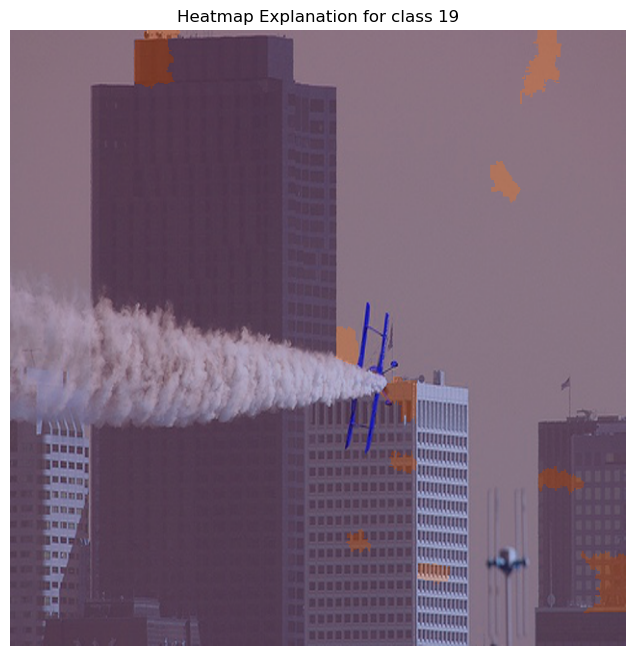

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

# YOLOv8 Wrapper Class
class YOLOv8Wrapper:
    def __init__(self, model, num_classes):
        self.model = model
        self.num_classes = num_classes  # Total number of classes in the YOLO model

    def predict(self, images):
        predictions = []
        for img in images:
            # Resize image to YOLO-compatible size
            img = Image.fromarray((img * 255).astype(np.uint8)).resize((640, 640))  # Convert back to uint8
            img_tensor = torch.tensor(np.array(img)).permute(2, 0, 1).unsqueeze(0)
            img_tensor = img_tensor.float().to('cuda' if torch.cuda.is_available() else 'cpu')
            
            # Normalize to 0-1 and predict
            img_tensor /= 255.0
            results = self.model.predict(img_tensor, imgsz=640, conf=0.25)
            
            # Initialize confidences for all classes as zeros
            confidences = np.zeros(self.num_classes)
            
            # Extract confidences from the predictions
            for box in results[0].boxes:
                class_id = int(box.cls)
                confidences[class_id] = max(confidences[class_id], box.conf.cpu().item())
            
            predictions.append(confidences)
        
        return np.array(predictions)

# Preprocess Input Image
def preprocess_image(image_path, img_size=640):
    image = Image.open(image_path).convert('RGB')
    # Resize to the required size while maintaining aspect ratio
    image = image.resize((img_size, img_size))  # YOLOv8 expects square inputs
    image_np = np.array(image) / 255.0  # Normalize to 0-1 as float32
    return image_np.astype(np.float32)

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Path to test image
test_image_path = 'yolo_dataset/images/val/2007_001377.jpg'  # Replace with an actual image path
image_np = preprocess_image(test_image_path, img_size=640)

# Target label for explanation (e.g., "dog")
num_classes = 20  # Replace with the actual number of classes in your YOLOv8 model
target_label = 0  # Replace with the index of the class you want to explain
model_wrapper = YOLOv8Wrapper(yolo8m_model, num_classes)

# Generate LIME explanation
explanation = explainer.explain_instance(
    image_np, 
    model_wrapper.predict, 
    top_labels=5,  # Retrieve explanations for top 5 labels
    hide_color=0, 
    num_samples=1000
)

print(f"Top labels in explanation: {explanation.top_labels}")

# Check if target label exists in the top labels
if target_label not in explanation.top_labels:
    print(f"Target label {target_label} not found in explanation. Using top predicted label instead.")
    target_label = explanation.top_labels[0]

# Get the image and mask for the target label
temp, mask = explanation.get_image_and_mask(
    target_label, 
    positive_only=True, 
    num_features=10, 
    hide_rest=False
)

# Convert the image back to uint8
image_uint8 = (image_np * 255).astype(np.uint8)

# Resize the mask to match the original image
heatmap_resized = cv2.resize(mask.astype(np.uint8), (image_uint8.shape[1], image_uint8.shape[0]))

# Convert heatmap to color
heatmap_colored = cv2.applyColorMap(heatmap_resized * 255, cv2.COLORMAP_JET)

# Overlay heatmap
image_with_heatmap = cv2.addWeighted(image_uint8, 0.7, heatmap_colored, 0.3, 0)

# Display the result
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image_with_heatmap, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Heatmap Explanation for class {target_label}")
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]


0: 640x640 2 tvmonitors, 161.9ms
Speed: 0.0ms preprocess, 161.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 aeroplane, 55.7ms
Speed: 0.0ms preprocess, 55.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pottedplant, 55.9ms
Speed: 0.0ms preprocess, 55.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 55.6ms
Speed: 0.0ms preprocess, 55.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 aeroplane, 57.7ms
Speed: 0.0ms preprocess, 57.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 aeroplanes, 1 person, 56.8ms
Speed: 0.0ms preprocess, 56.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bicycle, 1 person, 57.1ms
Speed: 0.0ms preprocess, 57.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 aeroplane, 55.6ms
Speed: 0.0ms preprocess, 55.6ms infer

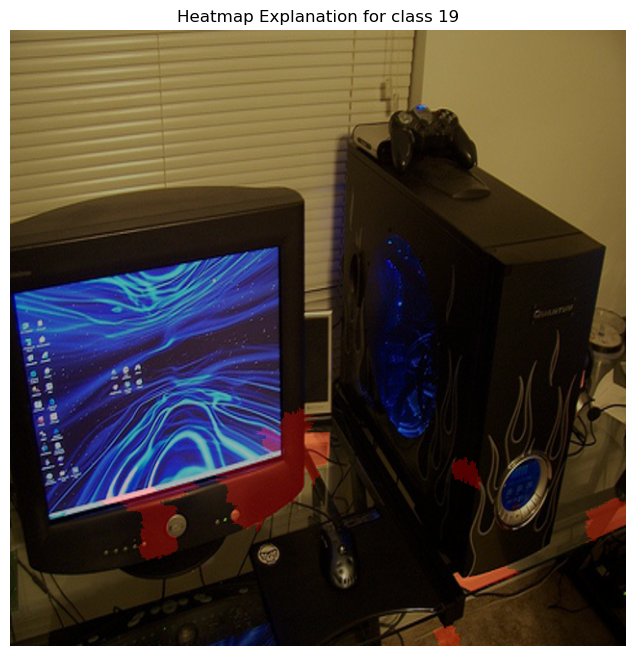

In [15]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

# YOLOv8 Wrapper Class
class YOLOv8Wrapper:
    def __init__(self, model, num_classes):
        self.model = model
        self.num_classes = num_classes  # Total number of classes in the YOLO model

    def predict(self, images):
        predictions = []
        for img in images:
            # Resize image to YOLO-compatible size
            img = Image.fromarray((img * 255).astype(np.uint8)).resize((640, 640))  # Convert back to uint8
            img_tensor = torch.tensor(np.array(img)).permute(2, 0, 1).unsqueeze(0)
            img_tensor = img_tensor.float().to('cuda' if torch.cuda.is_available() else 'cpu')
            
            # Normalize to 0-1 and predict
            img_tensor /= 255.0
            results = self.model.predict(img_tensor, imgsz=640, conf=0.25)
            
            # Initialize confidences for all classes as zeros
            confidences = np.zeros(self.num_classes)
            
            # Extract confidences from the predictions
            for box in results[0].boxes:
                class_id = int(box.cls)
                confidences[class_id] = max(confidences[class_id], box.conf.cpu().item())
            
            predictions.append(confidences)
        
        return np.array(predictions)

# Preprocess Input Image
def preprocess_image(image_path, img_size=640):
    image = Image.open(image_path).convert('RGB')
    # Resize to the required size while maintaining aspect ratio
    image = image.resize((img_size, img_size))  # YOLOv8 expects square inputs
    image_np = np.array(image) / 255.0  # Normalize to 0-1 as float32
    return image_np.astype(np.float32)

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Path to test image
test_image_path = 'yolo_dataset/images/val/2007_000187.jpg'  # Replace with an actual image path
image_np = preprocess_image(test_image_path, img_size=640)

# Target label for explanation (e.g., "dog")
num_classes = 20  # Replace with the actual number of classes in your YOLOv8 model
target_label = 19  # Replace with the index of the class you want to explain
model_wrapper = YOLOv8Wrapper(yolo8m_model, num_classes)

# Generate LIME explanation
explanation = explainer.explain_instance(
    image_np, 
    model_wrapper.predict, 
    top_labels=1, 
    hide_color=0, 
    num_samples=1000  # Number of perturbations
)

# Get LIME explanation mask and heatmap
temp, mask = explanation.get_image_and_mask(
    target_label, 
    positive_only=True, 
    num_features=10, 
    hide_rest=False
)

# Convert the mask to heatmap
heatmap = np.zeros_like(temp)
heatmap[mask == 1] = [1, 0, 0]  # Red color for positive features

# Resize the heatmap to match the original image size
heatmap_resized = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))

# Overlay the heatmap on the original image
image_with_heatmap = cv2.addWeighted(image_np, 0.7, heatmap_resized, 0.3, 0)

# Plot the image with heatmap overlay
plt.figure(figsize=(8, 8))
plt.imshow(image_with_heatmap)
plt.axis('off')
plt.title(f"Heatmap Explanation for class {target_label}")
plt.show()  # Ensure the plot is rendered in the notebook


  0%|          | 0/1000 [00:00<?, ?it/s]


0: 640x640 2 persons, 30.2ms
Speed: 0.0ms preprocess, 30.2ms inference, 73.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 28.5ms
Speed: 0.0ms preprocess, 28.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 30.1ms
Speed: 0.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 31.1ms
Speed: 0.0ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 29.1ms
Speed: 0.0ms preprocess, 29.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 31.0ms
Speed: 0.0ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 29.5ms
Speed: 0.0ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 30.0ms
Speed: 0.0ms preprocess, 30.0ms inference, 3.0ms postprocess per image a

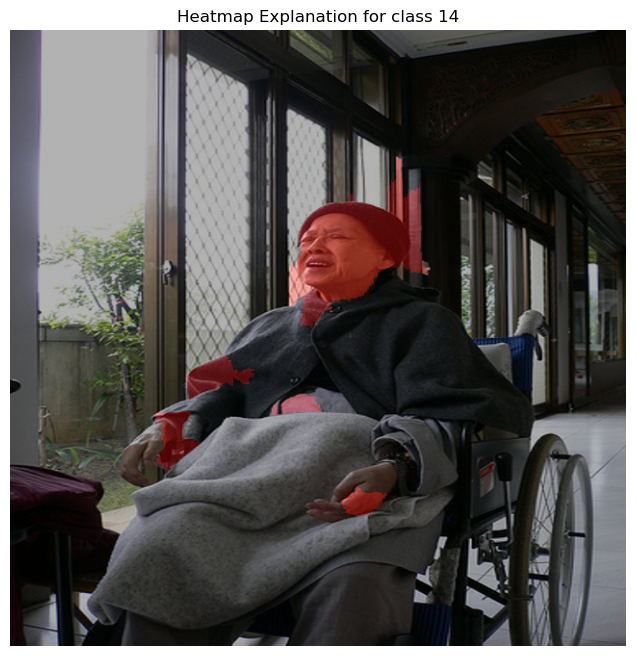

In [11]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

# YOLOv8 Wrapper Class
class YOLOv8Wrapper:
    def __init__(self, model, num_classes):
        self.model = model
        self.num_classes = num_classes  # Total number of classes in the YOLO model

    def predict(self, images):
        predictions = []
        for img in images:
            # Resize image to YOLO-compatible size
            img = Image.fromarray((img * 255).astype(np.uint8)).resize((640, 640))  # Convert back to uint8
            img_tensor = torch.tensor(np.array(img)).permute(2, 0, 1).unsqueeze(0)
            img_tensor = img_tensor.float().to('cuda' if torch.cuda.is_available() else 'cpu')
            
            # Normalize to 0-1 and predict
            img_tensor /= 255.0
            results = self.model.predict(img_tensor, imgsz=640, conf=0.25)
            
            # Initialize confidences for all classes as zeros
            confidences = np.zeros(self.num_classes)
            
            # Extract confidences from the predictions
            for box in results[0].boxes:
                class_id = int(box.cls)
                confidences[class_id] = max(confidences[class_id], box.conf.cpu().item())
            
            predictions.append(confidences)
        
        return np.array(predictions)

# Preprocess Input Image
def preprocess_image(image_path, img_size=640):
    image = Image.open(image_path).convert('RGB')
    # Resize to the required size while maintaining aspect ratio
    image = image.resize((img_size, img_size))  # YOLOv8 expects square inputs
    image_np = np.array(image) / 255.0  # Normalize to 0-1 as float32
    return image_np.astype(np.float32)

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Path to test image
test_image_path = 'yolo_test_dataset/images/test/2008_000325.jpg'  # Replace with an actual image path
image_np = preprocess_image(test_image_path, img_size=640)

# Target label for explanation (e.g., "dog")
num_classes = 20  # Replace with the actual number of classes in your YOLOv8 model
target_label = 14  # Replace with the index of the class you want to explain
model_wrapper = YOLOv8Wrapper(yolo8m_model, num_classes)

# Generate LIME explanation
explanation = explainer.explain_instance(
    image_np, 
    model_wrapper.predict, 
    top_labels=1, 
    hide_color=0, 
    num_samples=1000  # Number of perturbations
)

# Get LIME explanation mask and heatmap
temp, mask = explanation.get_image_and_mask(
    target_label, 
    positive_only=True, 
    num_features=10, 
    hide_rest=False
)

# Convert the mask to heatmap
heatmap = np.zeros_like(temp)
heatmap[mask == 1] = [1, 0, 0]  # Red color for positive features

# Resize the heatmap to match the original image size
heatmap_resized = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))

# Overlay the heatmap on the original image
image_with_heatmap = cv2.addWeighted(image_np, 0.7, heatmap_resized, 0.3, 0)

# Plot the image with heatmap overlay
plt.figure(figsize=(8, 8))
plt.imshow(image_with_heatmap)
plt.axis('off')
plt.title(f"Heatmap Explanation for class {target_label}")
plt.show()  # Ensure the plot is rendered in the notebook


In [ ]:
D:\Dhruv\Minor ODS\yolo_test_dataset\images\test\2008_000325.jpg

In [66]:
%pip install tensorflow


   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 0.8/390.3 MB 5.6 MB/s eta 0:01:10
   ---------------------------------------- 1.6/390.3 MB 6.0 MB/s eta 0:01:05
   ---------------------------------------- 3.1/390.3 MB 6.1 MB/s eta 0:01:03
   ---------------------------------------- 4.2/390.3 MB 5.7 MB/s eta 0:01:08
   ---------------------------------------- 4.7/390.3 MB 4.8 MB/s eta 0:01:20
    --------------------------------------- 6.0/390.3 MB 4.9 MB/s eta 0:01:19
    --------------------------------------- 6.3/390.3 MB 4.7 MB/s eta 0:01:22
    --------------------------------------- 7.3/390.3 MB 4.6 MB/s eta 0:01:24
    --------------------------------------- 7.3/390.3 MB 4.6 MB/s eta 0:01:24
    --------------------------------------- 7.3/390.3 MB 4.6 MB/s eta 0:01:24
    --------------------------------------- 7.6/390.3 MB 3.5 MB/s eta 0:01:50
    --------------------------------------- 7.9/390.3 MB 3.2 MB/s eta 0

In [8]:
import shap
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Wrapper for YOLOv8 Model
class YOLOv8Wrapper(torch.nn.Module):
    def __init__(self, yolo_model):
        super(YOLOv8Wrapper, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = yolo_model.model.to(self.device).eval()  # Move to device and set eval mode

    def forward(self, x):
        x = x.to(self.device)  # Ensure input tensor is on the same device
        predictions = self.model(x)  # Model returns a tuple
        return predictions[0]  # Extract the actual prediction (usually the first element in the tuple)

# Preprocess Input Image
def preprocess_image(image_path, img_size=640):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    image = Image.open(image_path).convert('RGB')
    image = image.resize((img_size, img_size))  # Resize to YOLOv8 input size
    image_np = np.array(image) / 255.0  # Normalize to 0-1
    image_tensor = torch.tensor(image_np).permute(2, 0, 1).unsqueeze(0).float()
    return image_tensor.to(device)  # Move to the same device

# Generate SHAP Explanation
def shap_explanation(image_tensor, model):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    baseline_data = torch.rand((10, 3, 640, 640)).to(device)  # Baseline on the same device
    
    # Initialize SHAP GradientExplainer
    explainer = shap.GradientExplainer(model, baseline_data)
    
    # Generate SHAP values
    shap_values = explainer.shap_values(image_tensor)
    return shap_values

# Load YOLOv8 model
model_path = './yolov8m_custmodel.pt'
yolo8m_model = YOLO(model_path)  # Reload the saved YOLOv8 model

# Wrap the YOLOv8 model for SHAP compatibility
model_wrapper = YOLOv8Wrapper(yolo8m_model)

# Preprocess the image
test_image_path = "yolo_dataset/images/val/2007_000272.jpg"  # Replace with your test image path
image_tensor = preprocess_image(test_image_path, img_size=640)

# Generate SHAP values
shap_values = shap_explanation(image_tensor, model_wrapper)

# Visualize SHAP Explanation
shap.initjs()
plt.figure(figsize=(10, 10))
plt.imshow(image_tensor.squeeze().permute(1, 2, 0).cpu().numpy())
plt.imshow(np.mean(shap_values[0], axis=1).squeeze(), cmap="viridis", alpha=0.5)
plt.title("SHAP Gradient Explanation")
plt.axis('off')
plt.show()


OutOfMemoryError: CUDA out of memory. Tried to allocate 470.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 10.46 GiB is allocated by PyTorch, and 123.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Training Yolov11 with 200 epochs

In [10]:
from ultralytics import YOLO

# Load YOLOv8 model
yolo11_model = YOLO('yolo11n.pt')  # YOLOv8 nano model

# Resume training
yolo11_model.train(
    data=os.path.join(yolo_dataset_path, 'data.yaml'),  # Dataset configuration
    epochs=100,                                         # Train for more epochs if needed
    imgsz=416,                                          # Adjust image size for balance
    batch=32,                                            # Experiment with batch size
    optimizer='AdamW',                                  # Faster optimizer
    lr0=0.001,                                          # Initial learning rate
    lrf=0.2,                                            # Final learning rate fraction
    weight_decay=0.0005,                                # Regularization (consider 0.01)
    amp=True,                                           # Enable mixed precision
    pretrained=True,                                    # Use pretrained weights
    augment=True,                                       # Enable data augmentation
    workers=4,                                          # Multi-threaded data loading
    name='yolov11n_custom',                             # Custom model name
    save=True,                                          # Save the best model
    save_period=5                                       # Save model every 5 epochs              
)



New https://pypi.org/project/ultralytics/8.3.32 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.28  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=./yolo_dataset\data.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=5, cache=False, device=None, workers=4, project=None, name=yolov11n_custom5, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None,

train: Scanning D:\Dhruv\Minor ODS\yolo_dataset\labels\train.cache... 13700 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13700/13700 [00:00<?, ?it/s]
val: Scanning D:\Dhruv\Minor ODS\yolo_dataset\labels\val.cache... 3425 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3425/3425 [00:00<?, ?it/s]


Plotting labels to runs\detect\yolov11n_custom5\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 4 dataloader workers
Logging results to runs\detect\yolov11n_custom5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.37G      1.213      2.287      1.302         10        416: 100%|██████████| 429/429 [02:35<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:21<00:00,  2.53it/s]


                   all       3425       7789      0.345       0.18      0.095     0.0444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.31G      1.289      1.969      1.378         30        416: 100%|██████████| 429/429 [02:45<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:38<00:00,  1.39it/s]


                   all       3425       7789      0.437      0.342       0.31      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.28G      1.281      1.909      1.379         21        416: 100%|██████████| 429/429 [02:37<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.33it/s]


                   all       3425       7789      0.438      0.327      0.305      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       2.2G      1.275      1.872      1.386         20        416: 100%|██████████| 429/429 [02:27<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:33<00:00,  1.61it/s]


                   all       3425       7789      0.449      0.291      0.272      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.19G      1.242      1.803       1.36         16        416: 100%|██████████| 429/429 [02:34<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:42<00:00,  1.28it/s]


                   all       3425       7789      0.465      0.385      0.382      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.26G      1.224      1.741       1.35         19        416: 100%|██████████| 429/429 [02:32<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.57it/s]


                   all       3425       7789      0.457      0.407       0.39      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.24G      1.197      1.697      1.331         23        416: 100%|██████████| 429/429 [02:22<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.33it/s]


                   all       3425       7789      0.509      0.375      0.382      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       2.3G      1.178      1.649      1.318         25        416: 100%|██████████| 429/429 [02:29<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.65it/s]


                   all       3425       7789      0.532      0.423      0.432      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       2.2G      1.158      1.614      1.305          8        416: 100%|██████████| 429/429 [02:17<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.62it/s]


                   all       3425       7789      0.511      0.421      0.421      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.13G      1.152      1.586        1.3         29        416: 100%|██████████| 429/429 [02:34<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:38<00:00,  1.42it/s]


                   all       3425       7789      0.503      0.434      0.437      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.18G      1.145      1.562      1.298          8        416: 100%|██████████| 429/429 [02:40<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:39<00:00,  1.35it/s]


                   all       3425       7789      0.551      0.448      0.464      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.17G      1.119       1.52       1.28          5        416: 100%|██████████| 429/429 [02:38<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.32it/s]


                   all       3425       7789      0.563      0.441      0.464       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.08G      1.117      1.521      1.284          9        416: 100%|██████████| 429/429 [02:36<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:42<00:00,  1.26it/s]


                   all       3425       7789      0.565      0.464      0.496      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.09G      1.107      1.481      1.275         13        416: 100%|██████████| 429/429 [02:34<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:44<00:00,  1.22it/s]


                   all       3425       7789      0.562      0.481      0.498      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.23G      1.097      1.464      1.267         19        416: 100%|██████████| 429/429 [02:37<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:41<00:00,  1.29it/s]


                   all       3425       7789        0.6      0.487       0.52      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.17G      1.095      1.455      1.263          9        416: 100%|██████████| 429/429 [02:37<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:38<00:00,  1.41it/s]


                   all       3425       7789      0.612      0.487      0.529      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.25G      1.085      1.435      1.257         29        416: 100%|██████████| 429/429 [02:39<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.33it/s]


                   all       3425       7789      0.607      0.507      0.537      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.25G      1.083      1.424      1.255         21        416: 100%|██████████| 429/429 [02:37<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:42<00:00,  1.27it/s]


                   all       3425       7789        0.6      0.498       0.53       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.09G      1.084      1.411      1.254         27        416: 100%|██████████| 429/429 [02:33<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:43<00:00,  1.24it/s]


                   all       3425       7789      0.649      0.502      0.556      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.16G      1.068      1.389      1.243         13        416: 100%|██████████| 429/429 [02:38<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:44<00:00,  1.21it/s]


                   all       3425       7789      0.621      0.513      0.549      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.16G      1.057      1.368      1.239         13        416: 100%|██████████| 429/429 [02:38<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.19it/s]


                   all       3425       7789      0.612      0.525      0.561      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.38G      1.056      1.367      1.237         14        416: 100%|██████████| 429/429 [02:39<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:26<00:00,  2.04it/s]

                   all       3425       7789      0.643      0.538       0.58      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.16G      1.061      1.358      1.236         40        416: 100%|██████████| 429/429 [02:33<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:42<00:00,  1.28it/s]


                   all       3425       7789      0.647      0.524      0.572      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.26G      1.047      1.347      1.232         18        416: 100%|██████████| 429/429 [02:38<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:41<00:00,  1.29it/s]


                   all       3425       7789       0.62      0.537      0.574      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.24G      1.046      1.334      1.231         20        416: 100%|██████████| 429/429 [02:37<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:41<00:00,  1.29it/s]


                   all       3425       7789      0.649      0.535      0.592       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.24G      1.042      1.322      1.223         23        416: 100%|██████████| 429/429 [02:38<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.20it/s]


                   all       3425       7789      0.639      0.561      0.599      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.19G      1.035      1.312      1.224         26        416: 100%|██████████| 429/429 [02:38<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:37<00:00,  1.43it/s]

                   all       3425       7789      0.664      0.545      0.599      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.28G      1.031      1.306      1.217         29        416: 100%|██████████| 429/429 [02:34<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:38<00:00,  1.39it/s]


                   all       3425       7789      0.669      0.545      0.606      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.26G      1.026      1.286      1.212         31        416: 100%|██████████| 429/429 [02:40<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.32it/s]


                   all       3425       7789      0.678      0.552      0.609      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.23G      1.016      1.277      1.211         24        416: 100%|██████████| 429/429 [02:37<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.34it/s]


                   all       3425       7789      0.663      0.565      0.614      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.19G       1.02      1.263      1.209         15        416: 100%|██████████| 429/429 [02:36<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:43<00:00,  1.25it/s]


                   all       3425       7789      0.667      0.567      0.619      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.15G      1.013       1.26      1.206         26        416: 100%|██████████| 429/429 [02:37<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:44<00:00,  1.22it/s]


                   all       3425       7789       0.66      0.577      0.622      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       2.2G      1.007       1.25      1.205         20        416: 100%|██████████| 429/429 [02:38<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:44<00:00,  1.21it/s]


                   all       3425       7789      0.694      0.562      0.628      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.29G       1.01      1.244      1.202         23        416: 100%|██████████| 429/429 [02:39<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.34it/s]


                   all       3425       7789       0.69      0.567      0.624      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.17G      1.005      1.223      1.199         38        416: 100%|██████████| 429/429 [02:40<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:41<00:00,  1.30it/s]


                   all       3425       7789      0.682      0.578       0.63      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.23G      1.004      1.228      1.198         19        416: 100%|██████████| 429/429 [02:40<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:42<00:00,  1.27it/s]


                   all       3425       7789      0.692      0.572       0.63      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.07G     0.9879      1.217      1.193         14        416: 100%|██████████| 429/429 [02:35<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:43<00:00,  1.25it/s]


                   all       3425       7789      0.665      0.592      0.631      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.18G     0.9916      1.218      1.193          8        416: 100%|██████████| 429/429 [02:37<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:42<00:00,  1.27it/s]


                   all       3425       7789      0.658      0.592      0.636      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.18G     0.9874        1.2      1.189         15        416: 100%|██████████| 429/429 [02:39<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:45<00:00,  1.20it/s]


                   all       3425       7789      0.689      0.581      0.636      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.08G     0.9914      1.196       1.19         50        416: 100%|██████████| 429/429 [02:35<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.32it/s]


                   all       3425       7789      0.675      0.587      0.639      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.17G     0.9799       1.19      1.185         36        416: 100%|██████████| 429/429 [02:39<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:39<00:00,  1.36it/s]


                   all       3425       7789      0.692      0.582       0.64      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       2.2G     0.9739      1.182      1.183         22        416: 100%|██████████| 429/429 [02:38<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:39<00:00,  1.36it/s]


                   all       3425       7789      0.687      0.587       0.64       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.16G      0.972      1.159      1.177         19        416: 100%|██████████| 429/429 [02:33<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.32it/s]


                   all       3425       7789      0.697       0.59      0.647      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.26G     0.9789      1.174      1.182         31        416: 100%|██████████| 429/429 [02:36<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:39<00:00,  1.37it/s]


                   all       3425       7789      0.676      0.605      0.648      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.16G     0.9717      1.157       1.18         16        416: 100%|██████████| 429/429 [02:37<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:41<00:00,  1.30it/s]


                   all       3425       7789      0.697      0.601      0.649      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.16G     0.9651      1.151      1.175         27        416: 100%|██████████| 429/429 [02:37<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:41<00:00,  1.30it/s]


                   all       3425       7789      0.703      0.595      0.652      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.23G     0.9613      1.143      1.172         28        416: 100%|██████████| 429/429 [03:32<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:01<00:00,  1.14s/it]


                   all       3425       7789      0.705      0.595      0.652      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.11G     0.9622      1.139      1.172         12        416: 100%|██████████| 429/429 [03:31<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


                   all       3425       7789      0.693        0.6      0.652      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.14G     0.9567      1.125      1.168          9        416: 100%|██████████| 429/429 [03:34<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


                   all       3425       7789      0.704      0.592      0.653      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.23G     0.9564      1.127      1.168         10        416: 100%|██████████| 429/429 [03:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.35it/s]


                   all       3425       7789      0.706      0.595      0.655       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.29G     0.9507      1.114      1.163         11        416: 100%|██████████| 429/429 [02:36<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:41<00:00,  1.31it/s]


                   all       3425       7789      0.697      0.601      0.653      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.35G      0.952      1.116      1.164         19        416: 100%|██████████| 429/429 [02:26<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:33<00:00,  1.61it/s]


                   all       3425       7789      0.696      0.602      0.656      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       2.2G     0.9533      1.115      1.165         25        416: 100%|██████████| 429/429 [02:37<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:37<00:00,  1.42it/s]


                   all       3425       7789      0.703      0.604       0.66      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       2.2G     0.9437        1.1       1.16         21        416: 100%|██████████| 429/429 [02:39<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:37<00:00,  1.45it/s]

                   all       3425       7789       0.72      0.601      0.662      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.25G     0.9443      1.099      1.161          6        416: 100%|██████████| 429/429 [02:36<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:39<00:00,  1.36it/s]


                   all       3425       7789      0.719      0.603      0.664      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.15G     0.9328      1.087      1.153         23        416: 100%|██████████| 429/429 [02:37<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.34it/s]


                   all       3425       7789      0.713      0.606      0.664      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.19G     0.9351      1.089      1.157         15        416: 100%|██████████| 429/429 [02:36<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.35it/s]


                   all       3425       7789      0.692       0.62      0.665      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.21G      0.936      1.079      1.154         24        416: 100%|██████████| 429/429 [02:21<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.32it/s]


                   all       3425       7789       0.72      0.613      0.668      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.19G     0.9288      1.065      1.152         16        416: 100%|██████████| 429/429 [02:38<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.33it/s]


                   all       3425       7789      0.714      0.614      0.669      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.19G     0.9279      1.072      1.151          8        416: 100%|██████████| 429/429 [02:37<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:39<00:00,  1.36it/s]


                   all       3425       7789      0.727      0.606      0.669      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.24G     0.9252      1.058      1.147         16        416: 100%|██████████| 429/429 [02:24<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:39<00:00,  1.36it/s]


                   all       3425       7789      0.717      0.612      0.669      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.09G     0.9315       1.06       1.15         26        416: 100%|██████████| 429/429 [02:37<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.32it/s]


                   all       3425       7789      0.727      0.607      0.669      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.26G     0.9254      1.054      1.148         25        416: 100%|██████████| 429/429 [02:26<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:32<00:00,  1.66it/s]


                   all       3425       7789      0.717      0.614      0.669      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.11G     0.9171       1.05      1.145         25        416: 100%|██████████| 429/429 [02:17<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:38<00:00,  1.42it/s]

                   all       3425       7789      0.713      0.616       0.67      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.16G     0.9223      1.047      1.147         26        416: 100%|██████████| 429/429 [02:34<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:39<00:00,  1.36it/s]

                   all       3425       7789       0.71      0.617      0.671      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.17G     0.9148      1.037       1.14         19        416: 100%|██████████| 429/429 [02:29<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:21<00:00,  2.55it/s]

                   all       3425       7789      0.715      0.615      0.671      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.15G     0.9113       1.03      1.138         15        416: 100%|██████████| 429/429 [02:19<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:29<00:00,  1.85it/s]

                   all       3425       7789      0.717      0.609      0.671      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       2.2G     0.9054      1.025      1.134         20        416: 100%|██████████| 429/429 [02:22<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:32<00:00,  1.68it/s]

                   all       3425       7789      0.703      0.621       0.67      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.18G     0.9167      1.033      1.141         19        416: 100%|██████████| 429/429 [02:21<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:30<00:00,  1.74it/s]

                   all       3425       7789      0.709      0.619      0.671      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.15G     0.9063      1.023      1.136         17        416: 100%|██████████| 429/429 [02:23<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.70it/s]

                   all       3425       7789      0.716      0.613       0.67      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       2.2G     0.9014      1.016      1.135         27        416: 100%|██████████| 429/429 [02:24<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.71it/s]

                   all       3425       7789      0.711      0.615      0.671      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.09G     0.9026      1.008      1.131         11        416: 100%|██████████| 429/429 [02:21<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:29<00:00,  1.84it/s]

                   all       3425       7789      0.714      0.618       0.67      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.29G     0.8984      1.007      1.133         10        416: 100%|██████████| 429/429 [02:24<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:27<00:00,  1.98it/s]

                   all       3425       7789      0.719      0.615       0.67      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.22G     0.9014      1.008      1.133         15        416: 100%|██████████| 429/429 [02:30<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.32it/s]


                   all       3425       7789      0.718      0.616      0.671      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.27G     0.8987     0.9983       1.13         19        416: 100%|██████████| 429/429 [02:36<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:37<00:00,  1.44it/s]


                   all       3425       7789      0.733      0.608      0.671      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.08G     0.8916     0.9867      1.127          8        416: 100%|██████████| 429/429 [02:36<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:21<00:00,  2.48it/s]

                   all       3425       7789      0.733      0.608      0.671      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.22G     0.8884     0.9854      1.125         24        416: 100%|██████████| 429/429 [02:36<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:39<00:00,  1.36it/s]

                   all       3425       7789      0.739      0.607      0.672      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.19G     0.8878     0.9856      1.125          8        416: 100%|██████████| 429/429 [02:38<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.34it/s]

                   all       3425       7789      0.738      0.605      0.672      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.18G     0.8885     0.9848      1.122         21        416: 100%|██████████| 429/429 [02:36<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:39<00:00,  1.36it/s]

                   all       3425       7789      0.729      0.609      0.672      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.25G     0.8808     0.9809      1.122         20        416: 100%|██████████| 429/429 [02:37<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:41<00:00,  1.31it/s]


                   all       3425       7789      0.727      0.612      0.672      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.17G     0.8916     0.9708      1.121         38        416: 100%|██████████| 429/429 [02:37<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:37<00:00,  1.44it/s]


                   all       3425       7789      0.732      0.608      0.672      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.26G     0.8791     0.9645      1.119         41        416: 100%|██████████| 429/429 [02:33<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:37<00:00,  1.42it/s]


                   all       3425       7789      0.729       0.61      0.672      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.31G     0.8783     0.9672      1.119         22        416: 100%|██████████| 429/429 [02:19<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:42<00:00,  1.26it/s]


                   all       3425       7789      0.733      0.609      0.671      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.25G     0.8813     0.9695      1.119         19        416: 100%|██████████| 429/429 [02:33<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:43<00:00,  1.23it/s]


                   all       3425       7789      0.737      0.608      0.671      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.23G     0.8807     0.9606      1.119         18        416: 100%|██████████| 429/429 [02:37<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:39<00:00,  1.36it/s]


                   all       3425       7789      0.733       0.61      0.671      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.09G     0.8699     0.9528      1.115         46        416: 100%|██████████| 429/429 [02:26<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.62it/s]

                   all       3425       7789      0.734       0.61      0.671      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       2.2G     0.8672      0.952      1.113         30        416: 100%|██████████| 429/429 [02:25<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:39<00:00,  1.36it/s]


                   all       3425       7789      0.726      0.614      0.671      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.21G     0.8708     0.9465      1.112         22        416: 100%|██████████| 429/429 [02:34<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.65it/s]

                   all       3425       7789      0.728      0.613      0.671      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.22G      0.868     0.9463      1.112         17        416: 100%|██████████| 429/429 [02:26<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.34it/s]


                   all       3425       7789      0.729      0.613      0.671      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.38G     0.8707     0.9375      1.113         29        416: 100%|██████████| 429/429 [02:38<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:37<00:00,  1.42it/s]

                   all       3425       7789      0.729      0.613      0.671      0.509


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.23G     0.8037     0.7592      1.053          5        416: 100%|██████████| 429/429 [02:37<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:38<00:00,  1.41it/s]


                   all       3425       7789      0.729      0.614      0.671      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.19G     0.7892     0.7206      1.043         12        416: 100%|██████████| 429/429 [02:32<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.32it/s]

                   all       3425       7789      0.733      0.612      0.671      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.26G     0.7883     0.7158       1.04         12        416: 100%|██████████| 429/429 [02:37<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.33it/s]

                   all       3425       7789      0.735      0.611      0.671       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.24G     0.7843      0.707      1.038          6        416: 100%|██████████| 429/429 [02:30<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:32<00:00,  1.66it/s]

                   all       3425       7789      0.734      0.611      0.671       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.16G     0.7799     0.6989      1.036         14        416: 100%|██████████| 429/429 [02:24<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:30<00:00,  1.74it/s]


                   all       3425       7789      0.735      0.612      0.671       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       2.1G      0.775     0.6907      1.033         10        416: 100%|██████████| 429/429 [02:21<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.71it/s]

                   all       3425       7789      0.736       0.61      0.671       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.17G      0.772      0.684      1.032          7        416: 100%|██████████| 429/429 [02:20<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.72it/s]

                   all       3425       7789      0.737       0.61      0.671       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.17G      0.766      0.674      1.028          7        416: 100%|██████████| 429/429 [02:22<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:27<00:00,  1.95it/s]

                   all       3425       7789      0.737      0.609      0.671       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.25G     0.7617     0.6713      1.023          7        416: 100%|██████████| 429/429 [02:19<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:30<00:00,  1.75it/s]

                   all       3425       7789      0.736       0.61      0.671       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.27G     0.7644      0.664      1.024         16        416: 100%|██████████| 429/429 [02:21<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:32<00:00,  1.69it/s]

                   all       3425       7789      0.736       0.61      0.671       0.51



100 epochs completed in 5.425 hours.
Optimizer stripped from runs\detect\yolov11n_custom5\weights\last.pt, 5.4MB
Optimizer stripped from runs\detect\yolov11n_custom5\weights\best.pt, 5.4MB

Validating runs\detect\yolov11n_custom5\weights\best.pt...
Ultralytics 8.3.28  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11n summary (fused): 238 layers, 2,586,052 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:43<00:00,  1.24it/s]


                   all       3425       7789      0.722      0.603      0.664      0.503
             aeroplane        140        195      0.881      0.728      0.826      0.666
               bicycle        117        150      0.595      0.553      0.585      0.456
                  bird        175        269      0.732      0.658      0.681      0.494
                  boat        126        255      0.704      0.424      0.521       0.31
                bottle        170        278      0.669      0.392      0.433      0.299
                   bus         92        130       0.83      0.785      0.814      0.698
                   car        264        506      0.756      0.512      0.626      0.463
                   cat        219        243      0.798      0.844      0.908      0.772
                 chair        243        509      0.586      0.395      0.454      0.334
                   cow         69        155      0.683      0.594      0.629      0.446
           diningtabl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001E76AEF70E0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0

In [11]:
# Save the trained YOLOv8 model
model_path = './yolov11n_custmodel.pt'
yolo11_model.save(model_path)


In [12]:
from ultralytics import YOLO

# Load the saved YOLOv8 model
model_11 = YOLO('yolov11n_custmodel.pt')


metrics2 = model_11.val(
    data=os.path.join(yolo_dataset_path, 'data.yaml'),
    batch=16,
    imgsz=640,
    conf=0.3,  # Lower confidence threshold
    iou=0.5
)

# Print out metrics
print("Evaluation Metrics:")
print(f"Precision: {metrics2.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall: {metrics2.results_dict['metrics/recall(B)']:.4f}")
# print(f"F1 Score: {metrics.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5: {metrics2.results_dict['metrics/mAP50(B)']:.4f}")  # mAP at IoU threshold of 0.5
print(f"mAP@0.5:0.95: {metrics2.results_dict['metrics/mAP50-95(B)']:.4f}")  # mAP averaged over IoU thresholds from 0.5 to 0.95
print(f"fitness: {metrics2.results_dict['fitness']:.4f}")



Ultralytics 8.3.28  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11n summary (fused): 238 layers, 2,586,052 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning D:\Dhruv\Minor ODS\yolo_dataset\labels\val.cache... 3425 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3425/3425 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 215/215 [00:43<00:00,  4.94it/s]


                   all       3425       7789       0.71      0.609      0.695      0.482
             aeroplane        140        195      0.851      0.738      0.818       0.54
               bicycle        117        150      0.554      0.553      0.607      0.395
                  bird        175        269      0.756      0.656       0.76      0.538
                  boat        126        255      0.717      0.467      0.602      0.373
                bottle        170        278      0.676      0.353      0.532      0.388
                   bus         92        130      0.808      0.777      0.847      0.691
                   car        264        506       0.77      0.584        0.7      0.506
                   cat        219        243      0.787      0.877        0.9      0.566
                 chair        243        509      0.644      0.379      0.522      0.398
                   cow         69        155      0.702      0.548      0.627      0.438
           diningtabl

In [ ]:
from ultralytics import YOLO

# Load YOLOv8 model
model2 = YOLO('yolov8n.pt')  # YOLOv8 nano model

# Set optimizer and train
model2.train(
    data=os.path.join(yolo_dataset_path, 'data.yaml'),  # Dataset configuration
    epochs=100,                    # Fewer epochs for faster training
    imgsz=416,                    # Reduce image size for faster processing
    batch=32,                     # Larger batch size for GPU efficiency
    optimizer='AdamW',            # Faster optimizer
    lr0=0.001,                    # Initial learning rate
    lrf=0.2,                      # Final learning rate as fraction of lr0
    weight_decay=0.01,            # Regularization
    amp=True,                     # Enable mixed precision
    pretrained=True,              # Use pretrained weights for faster convergence
    augment=False,                # Disable heavy augmentations
    workers=8,                    # Multi-threaded data loading
    name='yolov8_opt',
    save=True,  # Save the best model
    save_period=2   
)


New https://pypi.org/project/ultralytics/8.3.32 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.28  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=./yolo_dataset\data.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=2, cache=False, device=None, workers=8, project=None, name=yolov8_opt2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sho

train: Scanning D:\Dhruv\Minor ODS\yolo_dataset\labels\train.cache... 13700 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13700/13700 [00:00<?, ?it/s]
val: Scanning D:\Dhruv\Minor ODS\yolo_dataset\labels\val.cache... 3425 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3425/3425 [00:00<?, ?it/s]


Plotting labels to runs\detect\yolov8_opt2\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.01), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs\detect\yolov8_opt2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.11G      1.164      2.215      1.268         26        416: 100%|██████████| 429/429 [02:25<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:22<00:00,  2.40it/s]


                   all       3425       7789      0.462      0.104      0.102     0.0556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.97G       1.24       1.88      1.348         31        416: 100%|██████████| 429/429 [02:11<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.70it/s]


                   all       3425       7789      0.449      0.339      0.329       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.04G      1.248      1.823      1.357         14        416: 100%|██████████| 429/429 [02:08<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:21<00:00,  2.56it/s]

                   all       3425       7789      0.434      0.382      0.348      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.03G      1.238      1.804      1.362         15        416: 100%|██████████| 429/429 [02:16<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:38<00:00,  1.39it/s]


                   all       3425       7789      0.464      0.371      0.359      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.15G      1.218      1.755      1.349         28        416: 100%|██████████| 429/429 [02:16<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:30<00:00,  1.75it/s]


                   all       3425       7789      0.503      0.415      0.407      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.01G      1.186       1.68       1.33         21        416: 100%|██████████| 429/429 [02:20<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:36<00:00,  1.47it/s]


                   all       3425       7789      0.533      0.428      0.444      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.03G      1.174      1.625       1.32         19        416: 100%|██████████| 429/429 [02:24<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:38<00:00,  1.41it/s]


                   all       3425       7789      0.578      0.415      0.456      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.03G      1.149      1.576      1.307         14        416: 100%|██████████| 429/429 [02:14<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:30<00:00,  1.79it/s]


                   all       3425       7789      0.517      0.446      0.454      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.12G      1.141      1.562      1.298         21        416: 100%|██████████| 429/429 [02:13<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:30<00:00,  1.80it/s]


                   all       3425       7789      0.556      0.465       0.48      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.05G      1.119      1.528      1.288         37        416: 100%|██████████| 429/429 [02:12<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:32<00:00,  1.68it/s]


                   all       3425       7789      0.585      0.454      0.495      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.01G      1.115        1.5      1.286         27        416: 100%|██████████| 429/429 [02:12<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:30<00:00,  1.77it/s]


                   all       3425       7789      0.583      0.464      0.495      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.04G      1.103      1.476      1.275         11        416: 100%|██████████| 429/429 [02:14<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:30<00:00,  1.79it/s]


                   all       3425       7789      0.589      0.472      0.498      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.03G      1.096       1.46      1.268         15        416: 100%|██████████| 429/429 [02:13<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:30<00:00,  1.79it/s]


                   all       3425       7789      0.576      0.485      0.509      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.02G      1.088       1.44      1.267         13        416: 100%|██████████| 429/429 [02:11<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:21<00:00,  2.54it/s]

                   all       3425       7789      0.594      0.509      0.533      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.08G      1.078      1.415       1.26         20        416: 100%|██████████| 429/429 [02:07<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:36<00:00,  1.50it/s]


                   all       3425       7789      0.613      0.522      0.558      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.12G      1.061      1.397       1.25         22        416: 100%|██████████| 429/429 [02:25<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:39<00:00,  1.35it/s]


                   all       3425       7789      0.585        0.5      0.527      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.02G      1.068      1.376      1.248         14        416: 100%|██████████| 429/429 [02:25<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:41<00:00,  1.30it/s]


                   all       3425       7789      0.638      0.514      0.566      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.18G      1.056      1.368      1.246         19        416: 100%|██████████| 429/429 [02:25<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:42<00:00,  1.27it/s]


                   all       3425       7789      0.645      0.517      0.565      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.04G      1.056      1.359      1.246         12        416: 100%|██████████| 429/429 [02:24<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:37<00:00,  1.45it/s]


                   all       3425       7789       0.65      0.519      0.566      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.11G      1.051      1.353      1.238         19        416: 100%|██████████| 429/429 [02:26<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:39<00:00,  1.37it/s]


                   all       3425       7789      0.667      0.516      0.577      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.03G      1.047      1.325      1.234         13        416: 100%|██████████| 429/429 [02:25<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:36<00:00,  1.47it/s]


                   all       3425       7789      0.658      0.528      0.576      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.03G      1.034      1.317       1.23         20        416: 100%|██████████| 429/429 [02:24<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:41<00:00,  1.30it/s]


                   all       3425       7789      0.654      0.537       0.58      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.02G      1.036      1.311      1.228         17        416: 100%|██████████| 429/429 [02:18<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.74it/s]


                   all       3425       7789      0.664      0.537      0.588      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.05G      1.026      1.288      1.223         10        416: 100%|██████████| 429/429 [02:15<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:30<00:00,  1.78it/s]


                   all       3425       7789      0.657      0.555      0.598      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         2G      1.022      1.281      1.219         16        416: 100%|██████████| 429/429 [02:13<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:30<00:00,  1.75it/s]


                   all       3425       7789       0.66      0.549      0.599      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.01G      1.021      1.282      1.218         30        416: 100%|██████████| 429/429 [02:07<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.68it/s]

                   all       3425       7789      0.693      0.529      0.602      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.08G      1.017      1.263      1.217         19        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.65it/s]

                   all       3425       7789      0.696      0.542      0.609      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.93G      1.002      1.257      1.209          8        416: 100%|██████████| 429/429 [02:08<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.63it/s]

                   all       3425       7789      0.664      0.544      0.599      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.26G      1.006      1.241      1.209         31        416: 100%|██████████| 429/429 [02:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.66it/s]

                   all       3425       7789      0.708      0.546      0.616      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.94G      1.007      1.236      1.204         19        416: 100%|██████████| 429/429 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.67it/s]

                   all       3425       7789      0.667      0.564      0.616       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         2G      1.003      1.228      1.203         29        416: 100%|██████████| 429/429 [02:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.70it/s]

                   all       3425       7789      0.684      0.568      0.624      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         2G     0.9985      1.221      1.203         20        416: 100%|██████████| 429/429 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]

                   all       3425       7789      0.675      0.574      0.621      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.02G     0.9942      1.212      1.201         19        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.72it/s]

                   all       3425       7789       0.69      0.562      0.621      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.02G     0.9833      1.204      1.197         22        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]

                   all       3425       7789      0.707      0.555      0.627       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.99G      0.979      1.191      1.193         31        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]

                   all       3425       7789      0.688      0.567      0.625      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.23G     0.9862      1.183      1.191         25        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.72it/s]

                   all       3425       7789      0.683      0.582      0.629      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.13G     0.9782       1.17      1.192         11        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]

                   all       3425       7789        0.7      0.573      0.636      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.12G     0.9823      1.176      1.194         20        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]

                   all       3425       7789      0.703      0.577      0.641      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.01G      0.973       1.17      1.185         32        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]

                   all       3425       7789      0.698      0.581      0.636      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.03G     0.9682      1.154      1.181         14        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.72it/s]

                   all       3425       7789      0.701      0.583      0.642      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.12G     0.9646      1.149      1.184         26        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.76it/s]

                   all       3425       7789       0.71       0.58      0.644      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.03G     0.9664      1.145      1.183         11        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]

                   all       3425       7789      0.706      0.581      0.646      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.09G     0.9584      1.137      1.177         19        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]

                   all       3425       7789      0.708       0.58      0.644      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.12G     0.9528      1.134      1.175         10        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.70it/s]

                   all       3425       7789       0.71      0.576      0.646       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.08G     0.9518      1.128      1.173         18        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.70it/s]

                   all       3425       7789      0.714      0.582      0.647      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.04G     0.9509      1.118      1.171         21        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.72it/s]

                   all       3425       7789      0.698      0.593      0.645      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.01G     0.9463      1.114       1.17         19        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.74it/s]

                   all       3425       7789      0.703      0.592      0.646      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.24G     0.9473      1.109      1.167         20        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.72it/s]

                   all       3425       7789      0.706      0.595      0.652      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         2G     0.9433      1.103      1.168         12        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]

                   all       3425       7789      0.708      0.592      0.652      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.03G      0.942      1.098      1.167         28        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.70it/s]

                   all       3425       7789      0.728      0.583      0.653      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         2G     0.9354      1.084       1.16         27        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]

                   all       3425       7789      0.725      0.583      0.653      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.03G     0.9358      1.083      1.162         26        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]

                   all       3425       7789      0.731      0.582      0.656      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       2.2G     0.9331      1.078      1.161         26        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.72it/s]

                   all       3425       7789       0.72       0.59      0.657      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.93G     0.9316      1.078      1.159         29        416: 100%|██████████| 429/429 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]

                   all       3425       7789      0.735      0.588      0.658      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.03G     0.9332       1.07      1.157         31        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.69it/s]

                   all       3425       7789      0.738      0.585      0.658      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       2.1G     0.9275      1.071      1.153         13        416: 100%|██████████| 429/429 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]

                   all       3425       7789      0.731       0.59      0.657      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.13G     0.9257      1.064      1.156         19        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.75it/s]

                   all       3425       7789      0.719      0.597      0.658      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.15G     0.9236      1.052      1.149         18        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]

                   all       3425       7789      0.735      0.589      0.659      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.15G     0.9204      1.056      1.151         18        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.72it/s]

                   all       3425       7789      0.744      0.584      0.661      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         2G     0.9169      1.046       1.15         15        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.72it/s]

                   all       3425       7789      0.723      0.593       0.66      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.08G      0.915       1.04      1.147         11        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.75it/s]

                   all       3425       7789      0.727      0.595      0.661      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.15G      0.912      1.038      1.147         16        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.70it/s]

                   all       3425       7789      0.715      0.601      0.661      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.13G     0.9076      1.028      1.141         24        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.69it/s]

                   all       3425       7789      0.709      0.606      0.662      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.95G     0.9047      1.021      1.142         28        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]

                   all       3425       7789      0.724      0.595      0.662      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         2G     0.9063      1.021       1.14         23        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.72it/s]

                   all       3425       7789      0.741      0.591      0.664      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.12G     0.9023      1.014      1.141         14        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]

                   all       3425       7789       0.73        0.6      0.664      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.12G     0.9016      1.013      1.137         25        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.69it/s]

                   all       3425       7789      0.735      0.596      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.01G     0.9003       1.01      1.136         15        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.75it/s]

                   all       3425       7789      0.719      0.605      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.99G     0.8984      1.008      1.138         25        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.74it/s]

                   all       3425       7789      0.722      0.603      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.13G     0.8909      1.001      1.134         23        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.69it/s]

                   all       3425       7789      0.724        0.6      0.665      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.99G     0.8904     0.9923      1.133         27        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]

                   all       3425       7789       0.72      0.604      0.664        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.94G      0.894     0.9948      1.132         18        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.72it/s]

                   all       3425       7789      0.721      0.606      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.01G     0.8838     0.9849      1.126         16        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.72it/s]

                   all       3425       7789      0.719      0.608      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.01G     0.8853     0.9848      1.133         32        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]

                   all       3425       7789      0.723      0.608      0.666        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         2G     0.8864     0.9835      1.133          6        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]

                   all       3425       7789      0.726      0.608      0.667        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.01G     0.8861      0.978      1.129         19        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.75it/s]

                   all       3425       7789      0.722      0.607      0.666        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.91G     0.8813     0.9708      1.129         22        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.74it/s]

                   all       3425       7789       0.72      0.606      0.666      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.19G     0.8752     0.9651      1.122         10        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]

                   all       3425       7789      0.717      0.605      0.666      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.12G      0.884     0.9744      1.128         34        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]

                   all       3425       7789      0.723      0.604      0.666      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.03G     0.8757     0.9606      1.124         23        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.72it/s]

                   all       3425       7789       0.72      0.606      0.666      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         2G     0.8684      0.955      1.119         14        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.72it/s]

                   all       3425       7789       0.72      0.606      0.666      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.95G      0.873       0.96      1.123         21        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.69it/s]

                   all       3425       7789      0.722      0.606      0.666      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.09G     0.8729     0.9518      1.121         28        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]

                   all       3425       7789      0.722      0.607      0.666      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.03G     0.8719     0.9453      1.119         28        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]

                   all       3425       7789      0.724      0.606      0.666      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.92G     0.8673     0.9434       1.12         34        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]

                   all       3425       7789      0.728      0.603      0.666      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.02G     0.8671     0.9434      1.118         19        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]

                   all       3425       7789      0.737      0.599      0.666      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.07G     0.8642     0.9334      1.118          9        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]

                   all       3425       7789      0.727      0.606      0.666      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.12G     0.8588     0.9308      1.113         27        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.74it/s]

                   all       3425       7789      0.725      0.606      0.666      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.01G     0.8582     0.9276      1.114         11        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.70it/s]

                   all       3425       7789      0.729      0.605      0.666      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.11G      0.851      0.922      1.112         29        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.70it/s]

                   all       3425       7789      0.726      0.605      0.666      0.502


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.99G     0.8089     0.7623       1.06          5        416: 100%|██████████| 429/429 [02:02<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]

                   all       3425       7789      0.726      0.606      0.666      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.02G     0.7891     0.7228      1.048         14        416: 100%|██████████| 429/429 [02:02<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]

                   all       3425       7789      0.729      0.605      0.666      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.03G     0.7823     0.7181      1.045         11        416: 100%|██████████| 429/429 [02:02<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.69it/s]

                   all       3425       7789      0.722      0.607      0.666      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.02G     0.7768     0.7073       1.04          6        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.70it/s]

                   all       3425       7789      0.734      0.602      0.665      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.03G     0.7732     0.6992      1.038         14        416: 100%|██████████| 429/429 [02:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.69it/s]

                   all       3425       7789      0.735      0.602      0.666      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.05G     0.7678     0.6931      1.037         10        416: 100%|██████████| 429/429 [02:02<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.69it/s]

                   all       3425       7789      0.738        0.6      0.666      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.01G      0.773     0.6911      1.038          7        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.70it/s]

                   all       3425       7789      0.737        0.6      0.667      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         2G     0.7567      0.678      1.031          7        416: 100%|██████████| 429/429 [02:02<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]

                   all       3425       7789      0.735      0.605      0.667      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.99G     0.7609     0.6748      1.029          7        416: 100%|██████████| 429/429 [02:02<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]

                   all       3425       7789      0.738      0.604      0.667      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.03G     0.7556     0.6702      1.028         17        416: 100%|██████████| 429/429 [02:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.69it/s]

                   all       3425       7789      0.739      0.604      0.667      0.504



100 epochs completed in 4.204 hours.
Optimizer stripped from runs\detect\yolov8_opt2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\yolov8_opt2\weights\best.pt, 6.2MB

Validating runs\detect\yolov8_opt2\weights\best.pt...
Ultralytics 8.3.28  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 168 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:21<00:00,  2.47it/s]


                   all       3425       7789      0.738      0.604      0.666      0.504
             aeroplane        140        195      0.865      0.693      0.789      0.641
               bicycle        117        150      0.558      0.548      0.573      0.445
                  bird        175        269       0.76      0.628      0.684      0.493
                  boat        126        255      0.741      0.438      0.502      0.296
                bottle        170        278      0.752      0.374      0.442       0.31
                   bus         92        130      0.847      0.762      0.814      0.703
                   car        264        506       0.78      0.534      0.642      0.467
                   cat        219        243      0.836       0.84      0.913      0.777
                 chair        243        509      0.614      0.391      0.453      0.322
                   cow         69        155      0.718      0.592      0.667      0.487
           diningtabl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001CBB48C8590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0

In [9]:
# Save the trained YOLOv8 model
model_path = './yolov8_opt.pt'
model2.save(model_path)


In [10]:
from ultralytics import YOLO

# Load the saved YOLOv8 model
model = YOLO('yolov8_opt.pt')

# Set a limit for the number of images to display
display_limit = 5 # Change this to the desired number of images to show

# Run inference on validation set images with streaming enabled
results = model.predict(source=os.path.join(yolo_dataset_path, 'images/val'), save=True, stream=True)

# Display predictions up to the specified limit
for i, result in enumerate(results):
    if i >= display_limit:
        break  # Stop once the limit is reached
    result.show()  # Display each image with predictions



image 1/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000187.jpg: 480x640 1 tvmonitor, 47.1ms
image 2/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000272.jpg: 640x448 2 persons, 43.0ms
image 3/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000392.jpg: 448x640 2 persons, 46.2ms
image 4/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000648.jpg: 448x640 1 aeroplane, 1 bus, 1 car, 19.0ms
image 5/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000676.jpg: 480x640 2 sheeps, 23.0ms
image 6/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000727.jpg: 640x480 1 bus, 3 cars, 2 persons, 42.0ms


In [11]:
metrics2 = model.val(
    data=os.path.join(yolo_dataset_path, 'data.yaml'),
    batch=16,
    imgsz=640,
    conf=0.3,  # Lower confidence threshold
    iou=0.5
)

# Print out metrics
print("Evaluation Metrics:")
print(f"Precision: {metrics2.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall: {metrics2.results_dict['metrics/recall(B)']:.4f}")
# print(f"F1 Score: {metrics.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5: {metrics2.results_dict['metrics/mAP50(B)']:.4f}")  # mAP at IoU threshold of 0.5
print(f"mAP@0.5:0.95: {metrics2.results_dict['metrics/mAP50-95(B)']:.4f}")  # mAP averaged over IoU thresholds from 0.5 to 0.95
print(f"fitness: {metrics2.results_dict['fitness']:.4f}")

Ultralytics 8.3.28  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)


val: Scanning D:\Dhruv\Minor ODS\yolo_dataset\labels\val.cache... 3425 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3425/3425 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 215/215 [00:36<00:00,  5.93it/s]


                   all       3425       7789       0.67      0.603      0.661      0.448
             aeroplane        140        195      0.739      0.739      0.782      0.478
               bicycle        117        150      0.522      0.533      0.565      0.347
                  bird        175        269      0.725      0.658      0.734      0.525
                  boat        126        255      0.619      0.431      0.514      0.336
                bottle        170        278        0.7      0.403      0.547      0.394
                   bus         92        130      0.767       0.76      0.817      0.633
                   car        264        506       0.73      0.562      0.679      0.464
                   cat        219        243      0.672      0.848      0.828      0.507
                 chair        243        509      0.617      0.399      0.503      0.386
                   cow         69        155      0.659      0.524       0.63      0.429
           diningtabl

Train YOLOv8n Model

In [13]:
yaml_content = f"""
train: {os.path.join(yolo_dataset_path, 'images/train')}
val: {os.path.join(yolo_dataset_path, 'images/val')}

nc: {len(label_dict)}
names: {list(label_dict.keys())}
"""

# Save YAML configuration file
with open(os.path.join(yolo_dataset_path, 'data.yaml'), 'w') as f:
    f.write(yaml_content)


In [25]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO('yolov8n.pt')  # YOLOv8 nano model

# Train the model
model.train(
    data=os.path.join(yolo_dataset_path, 'data.yaml'),  # Path to dataset config file
    epochs=100,  # Number of epochs
    imgsz=640,  # Image size
    batch=16,  # Batch size
    name='yolov8_pascal_voc'  # Experiment name
)


Ultralytics 8.3.28  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=./yolo_dataset\data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8_pascal_voc5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

100%|██████████| 755k/755k [00:00<00:00, 8.98MB/s]

Overriding model.yaml nc=80 with nc=20

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

Model summary: 225 layers, 3,014,748 parameters, 3,014,732 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:02<00:00, 2.18MB/s]


AMP: checks passed 


train: Scanning D:\Dhruv\Minor ODS\yolo_dataset\labels\train... 13700 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13700/13700 [00:30<00:00, 444.74it/s]


train: New cache created: D:\Dhruv\Minor ODS\yolo_dataset\labels\train.cache


val: Scanning D:\Dhruv\Minor ODS\yolo_dataset\labels\val... 3425 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3425/3425 [00:07<00:00, 446.65it/s]


val: New cache created: D:\Dhruv\Minor ODS\yolo_dataset\labels\val.cache
Plotting labels to runs\detect\yolov8_pascal_voc5\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\yolov8_pascal_voc5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.39G     0.9907      2.671      1.267         29        640: 100%|██████████| 857/857 [04:59<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:32<00:00,  3.37it/s]


                   all       3425       7789      0.561       0.51      0.517      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       2.3G      1.095      2.056      1.345         27        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.05it/s]


                   all       3425       7789      0.413       0.38      0.342      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.29G      1.234      2.209       1.45         13        640: 100%|██████████| 857/857 [04:36<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:45<00:00,  2.37it/s]


                   all       3425       7789      0.383      0.289      0.259      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.36G      1.312      2.267      1.524         16        640: 100%|██████████| 857/857 [04:43<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:45<00:00,  2.38it/s]


                   all       3425       7789      0.426      0.344      0.326      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       2.4G      1.281        2.1      1.501         18        640: 100%|██████████| 857/857 [04:43<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:40<00:00,  2.64it/s]


                   all       3425       7789      0.453       0.36       0.35      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.46G      1.238      1.961      1.467         21        640: 100%|██████████| 857/857 [04:28<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:40<00:00,  2.65it/s]


                   all       3425       7789      0.478      0.401      0.371      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.47G      1.213      1.873      1.449         16        640: 100%|██████████| 857/857 [04:40<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:28<00:00,  3.73it/s]


                   all       3425       7789      0.518      0.432      0.437      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.48G       1.19       1.81      1.432         17        640: 100%|██████████| 857/857 [04:17<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:27<00:00,  4.00it/s]


                   all       3425       7789      0.505      0.443      0.438       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       2.4G      1.177      1.765      1.419         18        640: 100%|██████████| 857/857 [04:16<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.07it/s]


                   all       3425       7789      0.542      0.435      0.459      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.39G      1.149      1.699      1.403         27        640: 100%|██████████| 857/857 [04:22<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.03it/s]


                   all       3425       7789      0.559      0.481      0.508      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.41G      1.137       1.67      1.393         22        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.06it/s]


                   all       3425       7789      0.574      0.471      0.499      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.51G      1.127       1.64       1.39         13        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.05it/s]


                   all       3425       7789      0.587      0.475      0.507       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.62G      1.117      1.611      1.379         13        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.03it/s]


                   all       3425       7789      0.591      0.501      0.521      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.64G      1.099      1.585      1.369         13        640: 100%|██████████| 857/857 [04:14<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.10it/s]

                   all       3425       7789      0.618      0.501      0.547      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.39G      1.092      1.555      1.362         17        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.08it/s]


                   all       3425       7789      0.608      0.516      0.543      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.37G       1.09      1.529      1.353         28        640: 100%|██████████| 857/857 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.06it/s]

                   all       3425       7789      0.628       0.51      0.555      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.49G      1.078      1.512      1.345         12        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.06it/s]


                   all       3425       7789      0.631       0.53      0.569      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.51G      1.066      1.486      1.339         14        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.06it/s]

                   all       3425       7789      0.619      0.509      0.556       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.39G      1.056      1.473      1.336          7        640: 100%|██████████| 857/857 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.05it/s]

                   all       3425       7789      0.623       0.54       0.57      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.57G      1.056      1.461      1.336         22        640: 100%|██████████| 857/857 [04:14<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.08it/s]

                   all       3425       7789      0.643      0.532      0.579      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.61G      1.049      1.447      1.326         26        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.06it/s]

                   all       3425       7789      0.646      0.535      0.587      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.27G      1.041      1.432       1.32         25        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.07it/s]

                   all       3425       7789      0.626      0.552      0.589      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.42G      1.036      1.416      1.318         39        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.06it/s]

                   all       3425       7789      0.671      0.533      0.589      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.54G       1.03      1.403      1.311         15        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.06it/s]

                   all       3425       7789      0.667       0.55      0.607      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.29G      1.029      1.393      1.309         31        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.03it/s]


                   all       3425       7789      0.614      0.574      0.603      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.38G      1.031      1.389      1.313         21        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.06it/s]

                   all       3425       7789      0.655       0.57      0.616      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.47G      1.013      1.365      1.296         27        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.10it/s]

                   all       3425       7789      0.674       0.57      0.625      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.26G       1.01      1.353      1.298          6        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.07it/s]

                   all       3425       7789      0.689      0.561      0.625      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       2.4G      1.011      1.342      1.293         20        640: 100%|██████████| 857/857 [04:14<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.07it/s]

                   all       3425       7789      0.657      0.578      0.619      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       2.5G      1.006      1.331      1.289         16        640: 100%|██████████| 857/857 [04:14<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.06it/s]

                   all       3425       7789      0.698      0.553      0.627      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.66G     0.9984      1.322      1.288         14        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.05it/s]

                   all       3425       7789      0.663      0.588       0.63      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       2.4G      0.995      1.314      1.289         16        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.08it/s]

                   all       3425       7789      0.682      0.579      0.636       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.42G     0.9959      1.303      1.285         17        640: 100%|██████████| 857/857 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.09it/s]

                   all       3425       7789      0.698      0.584      0.644      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       2.5G     0.9895      1.294       1.28         32        640: 100%|██████████| 857/857 [04:13<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.10it/s]

                   all       3425       7789       0.67      0.588      0.642      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       2.4G     0.9859      1.289      1.278         51        640: 100%|██████████| 857/857 [04:14<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.07it/s]

                   all       3425       7789      0.686      0.582      0.641      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.48G     0.9785      1.272       1.27         21        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.09it/s]

                   all       3425       7789      0.716      0.574      0.645      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.36G     0.9703      1.263      1.271         15        640: 100%|██████████| 857/857 [04:14<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.10it/s]

                   all       3425       7789      0.693       0.58      0.642      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.51G     0.9685      1.261      1.266         22        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.06it/s]

                   all       3425       7789      0.694      0.587      0.648      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.56G     0.9672      1.254      1.266         10        640: 100%|██████████| 857/857 [04:14<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.08it/s]

                   all       3425       7789       0.72      0.576      0.649      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.36G     0.9648      1.253      1.264         21        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.11it/s]

                   all       3425       7789      0.705      0.586      0.653      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.38G     0.9576      1.241      1.258         12        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.06it/s]

                   all       3425       7789      0.692       0.61      0.662      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.48G     0.9547       1.23      1.257         13        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.08it/s]

                   all       3425       7789      0.697        0.6      0.664       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.51G     0.9467      1.213      1.249         14        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.07it/s]

                   all       3425       7789      0.707      0.594      0.663      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       2.4G     0.9564      1.223      1.257         13        640: 100%|██████████| 857/857 [04:14<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.06it/s]

                   all       3425       7789      0.695      0.606      0.661      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.27G      0.953      1.216      1.252         40        640: 100%|██████████| 857/857 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.08it/s]

                   all       3425       7789      0.685      0.614      0.661      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.51G     0.9461      1.195      1.246         27        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.09it/s]

                   all       3425       7789      0.694      0.617      0.667      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.36G     0.9428      1.194      1.249         12        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.08it/s]

                   all       3425       7789       0.69      0.621      0.672      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.38G     0.9391       1.18      1.244         15        640: 100%|██████████| 857/857 [04:16<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.08it/s]

                   all       3425       7789       0.73      0.592      0.669      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.38G     0.9325      1.166      1.239         21        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.11it/s]

                   all       3425       7789      0.711      0.606       0.67      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.48G     0.9354       1.17      1.241         29        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.07it/s]

                   all       3425       7789      0.711      0.615      0.675      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.38G     0.9263      1.163      1.233         12        640: 100%|██████████| 857/857 [04:14<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.07it/s]

                   all       3425       7789      0.706      0.623      0.675        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.26G     0.9239      1.146       1.23         18        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.08it/s]

                   all       3425       7789      0.719      0.616      0.676      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.38G     0.9234      1.151      1.233         19        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.08it/s]

                   all       3425       7789      0.716      0.617      0.677      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.46G     0.9148      1.138      1.227         20        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.06it/s]

                   all       3425       7789      0.709      0.617      0.677      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.38G     0.9171      1.136      1.227         17        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.09it/s]

                   all       3425       7789      0.705      0.618      0.675      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.48G     0.9103      1.128      1.222         11        640: 100%|██████████| 857/857 [04:16<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.09it/s]

                   all       3425       7789      0.704      0.625      0.677      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.36G     0.9155      1.127      1.225         15        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.05it/s]

                   all       3425       7789      0.718      0.619      0.679      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.35G     0.9122      1.114       1.22         17        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.07it/s]

                   all       3425       7789      0.715      0.623       0.68      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.36G     0.9008       1.11      1.216         20        640: 100%|██████████| 857/857 [04:14<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.10it/s]

                   all       3425       7789       0.73      0.615      0.682      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       2.5G     0.8984      1.109      1.215          9        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.10it/s]

                   all       3425       7789      0.726      0.618      0.683       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.51G     0.8939      1.093      1.209         10        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.07it/s]

                   all       3425       7789      0.717      0.628      0.683      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.62G     0.8909      1.086       1.21         17        640: 100%|██████████| 857/857 [04:13<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.12it/s]

                   all       3425       7789      0.714      0.631      0.684       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.28G     0.8919      1.087      1.209          9        640: 100%|██████████| 857/857 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.09it/s]

                   all       3425       7789      0.722      0.625      0.684      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.36G     0.8868       1.07      1.205         14        640: 100%|██████████| 857/857 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.07it/s]

                   all       3425       7789      0.718      0.631      0.685      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.49G     0.8878      1.075      1.202         30        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.11it/s]

                   all       3425       7789      0.724       0.63      0.684      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.48G     0.8816      1.076      1.201         19        640: 100%|██████████| 857/857 [04:14<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.09it/s]

                   all       3425       7789      0.727      0.628      0.686      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.28G     0.8756      1.057      1.199         13        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.09it/s]

                   all       3425       7789      0.725      0.626      0.685      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.24G     0.8746      1.048      1.198         12        640: 100%|██████████| 857/857 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.12it/s]

                   all       3425       7789      0.728      0.624      0.686      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.37G     0.8721      1.051      1.193         19        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.10it/s]

                   all       3425       7789      0.732      0.621      0.686      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.47G     0.8738       1.05      1.198         21        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.10it/s]

                   all       3425       7789      0.732      0.622      0.685      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.38G     0.8649      1.032      1.189         16        640: 100%|██████████| 857/857 [04:14<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.11it/s]

                   all       3425       7789      0.727      0.623      0.684      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.24G     0.8613      1.027      1.189         15        640: 100%|██████████| 857/857 [04:16<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.04it/s]

                   all       3425       7789      0.725      0.624      0.685      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.48G     0.8578       1.02      1.184         32        640: 100%|██████████| 857/857 [04:14<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.05it/s]

                   all       3425       7789      0.735      0.617      0.685      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.49G     0.8566      1.017      1.184         25        640: 100%|██████████| 857/857 [04:16<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.06it/s]

                   all       3425       7789       0.73      0.622      0.685      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.33G     0.8524      1.011      1.184         22        640: 100%|██████████| 857/857 [04:16<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.03it/s]

                   all       3425       7789      0.725      0.624      0.685      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.61G     0.8475      1.004      1.178         12        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.03it/s]

                   all       3425       7789      0.729      0.624      0.686      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.39G     0.8502     0.9997      1.178         20        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.03it/s]

                   all       3425       7789      0.732      0.622      0.686      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.25G     0.8447     0.9878      1.174          8        640: 100%|██████████| 857/857 [04:16<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.03it/s]

                   all       3425       7789      0.729      0.626      0.686      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.55G     0.8485     0.9866      1.177         11        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.03it/s]

                   all       3425       7789      0.728      0.625      0.686      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.34G     0.8411     0.9838      1.171         34        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.01it/s]

                   all       3425       7789      0.727      0.627      0.687      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.35G     0.8428     0.9807      1.175         19        640: 100%|██████████| 857/857 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.03it/s]

                   all       3425       7789      0.729      0.625      0.686      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.72G     0.8335     0.9727      1.171         14        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.07it/s]

                   all       3425       7789      0.731      0.623      0.687      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.47G     0.8345     0.9673      1.167         17        640: 100%|██████████| 857/857 [04:16<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.05it/s]

                   all       3425       7789       0.73      0.623      0.687      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.46G     0.8294     0.9591      1.163         23        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.05it/s]

                   all       3425       7789      0.729      0.623      0.687      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.49G     0.8288      0.953      1.165         16        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.04it/s]

                   all       3425       7789      0.727      0.624      0.687      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.52G     0.8223     0.9473      1.162         12        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.02it/s]

                   all       3425       7789      0.727      0.625      0.687      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.36G     0.8201      0.943      1.158         15        640: 100%|██████████| 857/857 [04:14<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.08it/s]

                   all       3425       7789       0.73      0.626      0.687      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.47G     0.8166     0.9318      1.156         28        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.02it/s]

                   all       3425       7789      0.731      0.625      0.687      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.38G     0.8122     0.9315      1.155         32        640: 100%|██████████| 857/857 [04:16<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.02it/s]

                   all       3425       7789      0.731      0.625      0.687      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.28G     0.8115     0.9236      1.153         18        640: 100%|██████████| 857/857 [04:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.02it/s]

                   all       3425       7789       0.73      0.626      0.688      0.514


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.36G     0.7751     0.7802      1.119          5        640: 100%|██████████| 857/857 [04:13<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.04it/s]

                   all       3425       7789      0.728      0.627      0.688      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.33G     0.7609     0.7475      1.111         14        640: 100%|██████████| 857/857 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.04it/s]

                   all       3425       7789      0.727      0.627      0.687      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.37G     0.7517     0.7356      1.107         11        640: 100%|██████████| 857/857 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.05it/s]

                   all       3425       7789      0.727      0.629      0.687      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.37G     0.7429     0.7175      1.096          6        640: 100%|██████████| 857/857 [04:13<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.06it/s]

                   all       3425       7789      0.727      0.628      0.687      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.39G     0.7378      0.708      1.093         14        640: 100%|██████████| 857/857 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.05it/s]

                   all       3425       7789      0.723      0.631      0.687      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.37G     0.7314     0.7063      1.091         10        640: 100%|██████████| 857/857 [04:13<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.03it/s]

                   all       3425       7789      0.722      0.633      0.687      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.35G     0.7304     0.6974      1.087          7        640: 100%|██████████| 857/857 [04:12<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.05it/s]

                   all       3425       7789       0.72      0.635      0.687      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.36G     0.7208     0.6921      1.082          7        640: 100%|██████████| 857/857 [04:13<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.04it/s]

                   all       3425       7789      0.719      0.634      0.687      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.36G     0.7201     0.6808       1.08          7        640: 100%|██████████| 857/857 [04:13<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.03it/s]

                   all       3425       7789      0.719      0.634      0.687      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.36G      0.716     0.6742      1.077         17        640: 100%|██████████| 857/857 [04:13<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.02it/s]

                   all       3425       7789      0.721      0.633      0.686      0.514



100 epochs completed in 7.918 hours.
Optimizer stripped from runs\detect\yolov8_pascal_voc5\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\yolov8_pascal_voc5\weights\best.pt, 6.2MB

Validating runs\detect\yolov8_pascal_voc5\weights\best.pt...
Ultralytics 8.3.28  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 168 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:26<00:00,  4.09it/s]


                   all       3425       7789      0.726      0.627      0.686      0.515
             aeroplane        140        195      0.878      0.764      0.833      0.632
               bicycle        117        150      0.656      0.553      0.634       0.47
                  bird        175        269      0.782      0.695      0.736      0.537
                  boat        126        255      0.652      0.451      0.512      0.325
                bottle        170        278      0.782      0.425      0.502      0.358
                   bus         92        130       0.79      0.792       0.83      0.716
                   car        264        506      0.762      0.595      0.688      0.502
                   cat        219        243      0.834      0.823      0.897      0.715
                 chair        243        509      0.617       0.42      0.483      0.359
                   cow         69        155      0.669      0.632      0.686      0.482
           diningtabl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000020E932DB410>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0

In [ ]:
# Save the trained YOLOv8 model
model_path = './yolov8_pascal_voc.pt'
model.save(model_path)


In [11]:
from ultralytics import YOLO

# Load the saved YOLOv8 model
model = YOLO('yolov8_pascal_voc.pt')


In [37]:
# Set a limit for the number of images to display
display_limit = 5 # Change this to the desired number of images to show

# Run inference on validation set images with streaming enabled
results = model.predict(source=os.path.join(yolo_dataset_path, 'images/val'), save=True, stream=True)

# Display predictions up to the specified limit
for i, result in enumerate(results):
    if i >= display_limit:
        break  # Stop once the limit is reached
    result.show()  # Display each image with predictions



image 1/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000187.jpg: 480x640 2 tvmonitors, 22.2ms
image 2/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000272.jpg: 640x448 1 person, 21.0ms
image 3/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000392.jpg: 448x640 1 car, 1 horse, 2 persons, 18.7ms
image 4/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000648.jpg: 448x640 1 aeroplane, 1 bus, 1 car, 4 persons, 16.0ms
image 5/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000676.jpg: 480x640 1 sheep, 18.0ms
image 6/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000727.jpg: 640x480 1 bus, 1 car, 4 persons, 22.0ms


In [ ]:
from ultralytics import YOLO
import os

# Load the saved YOLOv8 model
model2 = YOLO('yolov8_pascal_voc.pt')


metrics2 = model2.val(
    data=os.path.join(yolo_dataset_path, 'data.yaml'),
    batch=16,
    imgsz=640,
    conf=0.3,  # Lower confidence threshold
    iou=0.5
)

# Print out metrics
print("Evaluation Metrics:")
print(f"Precision: {metrics2.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall: {metrics2.results_dict['metrics/recall(B)']:.4f}")
# print(f"F1 Score: {metrics.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5: {metrics2.results_dict['metrics/mAP50(B)']:.4f}")  # mAP at IoU threshold of 0.5
print(f"mAP@0.5:0.95: {metrics2.results_dict['metrics/mAP50-95(B)']:.4f}")  # mAP averaged over IoU thresholds from 0.5 to 0.95
print(f"fitness: {metrics2.results_dict['fitness']:.4f}")



Ultralytics 8.3.28  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 168 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\Dhruv\Minor ODS\yolo_test_dataset\labels\test.cache... 5138 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5138/5138 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 322/322 [00:46<00:00,  6.97it/s]


                   all       5138       7330      0.262      0.432      0.284      0.233
                 chair          1          2          0          0          0          0
           diningtable          2          2      0.016        0.5     0.0242     0.0157
                person       5138       7326      0.771      0.795      0.828      0.683
Speed: 0.2ms preprocess, 5.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\val28
Evaluation Metrics:
Precision: 0.2623
Recall: 0.4317
mAP@0.5: 0.2842
mAP@0.5:0.95: 0.2329
fitness: 0.2381


In [24]:
# Set a limit for the number of images to display
display_limit = 5 # Change this to the desired number of images to show

# Run inference on validation set images with streaming enabled
results = model4.predict(source=os.path.join(yolo_dataset_path, 'images/val'), save=True, stream=True)

# Display predictions up to the specified limit
for i, result in enumerate(results):
    if i >= display_limit:
        break  # Stop once the limit is reached
    result.show()  # Display each image with predictions



image 1/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000187.jpg: 480x640 1 tv, 1 mouse, 1 keyboard, 39.6ms
image 2/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000272.jpg: 640x448 1 person, 1 cup, 2 chairs, 46.5ms
image 3/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000392.jpg: 448x640 6 persons, 1 car, 1 horse, 58.5ms
image 4/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000648.jpg: 448x640 5 persons, 1 car, 1 airplane, 1 bus, 17.0ms
image 5/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000676.jpg: 480x640 1 sheep, 21.0ms
image 6/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000727.jpg: 640x480 3 persons, 5 cars, 1 bus, 3 traffic lights, 1 fire hydrant, 53.5ms


Evaluation of the Model

In [38]:

metrics = model.val(
    data=os.path.join(yolo_dataset_path, 'data.yaml'),
    batch=16,
    imgsz=640,
    conf=0.3,  # Lower confidence threshold
    iou=0.5
)


Ultralytics 8.3.28  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)


val: Scanning D:\Dhruv\Minor ODS\yolo_dataset\labels\val.cache... 3425 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3425/3425 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 215/215 [00:33<00:00,  6.34it/s]


                   all       3425       7789       0.74       0.63      0.716      0.573
             aeroplane        140        195      0.914       0.76      0.854      0.699
               bicycle        117        150      0.653      0.564      0.652      0.525
                  bird        175        269      0.788      0.691      0.784      0.608
                  boat        126        255      0.682      0.454      0.579      0.407
                bottle        170        278      0.777      0.435      0.602      0.468
                   bus         92        130      0.802      0.792      0.866      0.771
                   car        264        506      0.764      0.597      0.719      0.575
                   cat        219        243      0.845      0.827      0.883      0.741
                 chair        243        509      0.622      0.418       0.54      0.434
                   cow         69        155      0.694      0.628      0.695      0.514
           diningtabl

In [15]:
print(metrics)

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001EA4235A330>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0

In [39]:
# Print out metrics
print("Evaluation Metrics:")
print(f"Precision: {metrics.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall: {metrics.results_dict['metrics/recall(B)']:.4f}")
# print(f"F1 Score: {metrics.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5: {metrics.results_dict['metrics/mAP50(B)']:.4f}")  # mAP at IoU threshold of 0.5
print(f"mAP@0.5:0.95: {metrics.results_dict['metrics/mAP50-95(B)']:.4f}")  # mAP averaged over IoU thresholds from 0.5 to 0.95
print(f"fitness: {metrics.results_dict['fitness']:.4f}")

Evaluation Metrics:
Precision: 0.7404
Recall: 0.6299
mAP@0.5: 0.7158
mAP@0.5:0.95: 0.5727
fitness: 0.5870


In [ ]:
yolo_dataset/images/val/2007_000187.jpg

XAI Techniques

In [29]:
import torch
from torchcam.methods import GradCAM
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO('yolov8_pascal_voc.pt')  # Use your model path, such as 'yolov8n.pt'

# Load an image for explanation
img_path = 'yolo_dataset/images/val/2007_000187.jpg'
img = Image.open(img_path).convert('RGB')
img = np.array(img)

# Convert the image to a tensor and normalize it if needed
# YOLOv8 automatically handles preprocessing when feeding into the model, so no manual preprocessing is required
img_tensor = torch.from_numpy(img).permute(2, 0, 1).float()  # Convert to [C, H, W]
img_tensor = img_tensor / 255.0  # Normalize to [0, 1] if needed

# Add batch dimension (batch size of 1)
img_tensor = img_tensor.unsqueeze(0)

# Get the GradCAM explanation method
cam = GradCAM(model.model, target_layers=[model.model.model[0]])

# Generate the heatmap
grayscale_cam = cam(img_tensor)
grayscale_cam = grayscale_cam[0, :]  # Get the first (and only) sample in the batch

# Convert heatmap to image
heatmap = np.uint8(255 * grayscale_cam)
heatmap = np.expand_dims(heatmap, axis=-1)
heatmap = np.repeat(heatmap, 3, axis=-1)
superimposed_img = np.uint8(np.clip(heatmap * 0.4 + img, 0, 255))

# Display the superimposed image
plt.imshow(superimposed_img)
plt.show()


TypeError: _CAM.__init__() got an unexpected keyword argument 'target_layers'

In [1]:

import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda


In [14]:
!python ./Minor_Project_Object_Detection_Using_YOLOv8_in_Pascal_VOC.ipynb --batch 32 --device 0,1  # Use 2 GPUs for distributed training


Traceback (most recent call last):
  File "d:\Dhruv\Minor ODS\Minor_Project_Object_Detection_Using_YOLOv8_in_Pascal_VOC.ipynb", line 43, in <module>
    "execution_count": null,
                       ^^^^
NameError: name 'null' is not defined


In [9]:
from ultralytics import YOLO

# Load YOLOv8 model
model2 = YOLO('yolov8n.pt')  # YOLOv8 nano model

# Set optimizer and train
model2.train(
    data=os.path.join(yolo_dataset_path, 'data.yaml'),  # Dataset configuration
    epochs=100,                    # Fewer epochs for faster training
    imgsz=416,                    # Reduce image size for faster processing
    batch=32,                     # Larger batch size for GPU efficiency
    optimizer='AdamW',            # Faster optimizer
    lr0=0.001,                    # Initial learning rate
    lrf=0.2,                      # Final learning rate as fraction of lr0
    weight_decay=0.01,            # Regularization
    amp=True,                     # Enable mixed precision
    pretrained=True,              # Use pretrained weights for faster convergence
    augment=False,                # Disable heavy augmentations
    workers=8,                    # Multi-threaded data loading
    name='yolov8_fast_train'   
)


New https://pypi.org/project/ultralytics/8.3.32 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.28  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=./yolo_dataset\data.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8_fast_train2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=N

train: Scanning D:\Dhruv\Minor ODS\yolo_dataset\labels\train.cache... 13700 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13700/13700 [00:00<?, ?it/s]
val: Scanning D:\Dhruv\Minor ODS\yolo_dataset\labels\val.cache... 3425 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3425/3425 [00:00<?, ?it/s]


Plotting labels to runs\detect\yolov8_fast_train2\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.01), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs\detect\yolov8_fast_train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.11G      1.164      2.215      1.268         26        416: 100%|██████████| 429/429 [02:16<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.70it/s]


                   all       3425       7789      0.462      0.104      0.102     0.0556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.97G       1.24       1.88      1.348         31        416: 100%|██████████| 429/429 [02:07<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.74it/s]


                   all       3425       7789      0.449      0.339      0.329       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.04G      1.248      1.823      1.357         14        416: 100%|██████████| 429/429 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.77it/s]

                   all       3425       7789      0.434      0.382      0.348      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.03G      1.238      1.804      1.362         15        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]


                   all       3425       7789      0.464      0.371      0.359      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.15G      1.218      1.755      1.349         28        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]


                   all       3425       7789      0.503      0.415      0.407      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.01G      1.186       1.68       1.33         21        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.74it/s]


                   all       3425       7789      0.533      0.428      0.444      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.03G      1.174      1.625       1.32         19        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.76it/s]

                   all       3425       7789      0.578      0.415      0.456      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.03G      1.149      1.576      1.307         14        416: 100%|██████████| 429/429 [02:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.75it/s]

                   all       3425       7789      0.517      0.446      0.454      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.12G      1.141      1.562      1.298         21        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.72it/s]


                   all       3425       7789      0.556      0.465       0.48      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.05G      1.119      1.528      1.288         37        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.79it/s]

                   all       3425       7789      0.585      0.454      0.495      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.01G      1.115        1.5      1.286         27        416: 100%|██████████| 429/429 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.77it/s]

                   all       3425       7789      0.583      0.464      0.495      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.04G      1.103      1.476      1.275         11        416: 100%|██████████| 429/429 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.74it/s]

                   all       3425       7789      0.589      0.472      0.498      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.03G      1.096       1.46      1.268         15        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.72it/s]

                   all       3425       7789      0.576      0.485      0.509      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.02G      1.088       1.44      1.267         13        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.76it/s]

                   all       3425       7789      0.594      0.509      0.533      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.08G      1.078      1.415       1.26         20        416: 100%|██████████| 429/429 [02:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.74it/s]

                   all       3425       7789      0.613      0.522      0.558      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.12G      1.061      1.397       1.25         22        416: 100%|██████████| 429/429 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.74it/s]

                   all       3425       7789      0.585        0.5      0.527      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.02G      1.068      1.376      1.248         14        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]

                   all       3425       7789      0.638      0.514      0.566      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.18G      1.056      1.368      1.246         19        416: 100%|██████████| 429/429 [02:08<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:22<00:00,  2.35it/s]

                   all       3425       7789      0.645      0.517      0.565      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.04G      1.056      1.359      1.246         12        416: 100%|██████████| 429/429 [02:10<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:22<00:00,  2.36it/s]


                   all       3425       7789       0.65      0.519      0.566      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.11G      1.051      1.353      1.238         19        416: 100%|██████████| 429/429 [02:10<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:22<00:00,  2.38it/s]

                   all       3425       7789      0.667      0.516      0.577      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.03G      1.047      1.325      1.234         13        416: 100%|██████████| 429/429 [02:11<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:22<00:00,  2.36it/s]


                   all       3425       7789      0.658      0.528      0.576      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.03G      1.034      1.317       1.23         20        416: 100%|██████████| 429/429 [02:12<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:22<00:00,  2.35it/s]

                   all       3425       7789      0.654      0.537       0.58      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.02G      1.036      1.311      1.228         17        416: 100%|██████████| 429/429 [02:11<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:22<00:00,  2.37it/s]


                   all       3425       7789      0.664      0.537      0.588      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.05G      1.026      1.288      1.223         10        416: 100%|██████████| 429/429 [02:11<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:22<00:00,  2.35it/s]


                   all       3425       7789      0.657      0.555      0.598      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         2G      1.022      1.281      1.219         16        416: 100%|██████████| 429/429 [02:11<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:22<00:00,  2.39it/s]


                   all       3425       7789       0.66      0.549      0.599      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.01G      1.021      1.282      1.218         30        416: 100%|██████████| 429/429 [02:11<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:22<00:00,  2.36it/s]

                   all       3425       7789      0.693      0.529      0.602      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.08G      1.017      1.263      1.217         19        416: 100%|██████████| 429/429 [02:12<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:22<00:00,  2.37it/s]

                   all       3425       7789      0.696      0.542      0.609      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.93G      1.002      1.257      1.209          8        416: 100%|██████████| 429/429 [02:13<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:22<00:00,  2.36it/s]

                   all       3425       7789      0.664      0.544      0.599      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.26G      1.006      1.241      1.209         31        416: 100%|██████████| 429/429 [02:14<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:22<00:00,  2.36it/s]

                   all       3425       7789      0.708      0.546      0.616      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.94G      1.007      1.236      1.204         19        416: 100%|██████████| 429/429 [08:37<00:00,  1.21s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]

                   all       3425       7789      0.667      0.564      0.616       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         2G      1.003      1.228      1.203         29        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.75it/s]

                   all       3425       7789      0.684      0.568      0.624      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         2G     0.9985      1.221      1.203         20        416: 100%|██████████| 429/429 [02:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.76it/s]

                   all       3425       7789      0.675      0.574      0.621      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.02G     0.9942      1.212      1.201         19        416: 100%|██████████| 429/429 [02:05<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.74it/s]

                   all       3425       7789       0.69      0.562      0.621      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.02G     0.9833      1.204      1.197         22        416: 100%|██████████| 429/429 [02:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.75it/s]

                   all       3425       7789      0.707      0.555      0.627       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.99G      0.979      1.191      1.193         31        416: 100%|██████████| 429/429 [02:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]

                   all       3425       7789      0.688      0.567      0.625      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.23G     0.9862      1.183      1.191         25        416: 100%|██████████| 429/429 [02:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.72it/s]

                   all       3425       7789      0.683      0.582      0.629      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.13G     0.9782       1.17      1.192         11        416: 100%|██████████| 429/429 [02:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]

                   all       3425       7789        0.7      0.573      0.636      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.12G     0.9823      1.176      1.194         20        416: 100%|██████████| 429/429 [02:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.81it/s]

                   all       3425       7789      0.703      0.577      0.641      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.01G      0.973       1.17      1.185         32        416: 100%|██████████| 429/429 [02:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.77it/s]

                   all       3425       7789      0.698      0.581      0.636      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.03G     0.9682      1.154      1.181         14        416: 100%|██████████| 429/429 [02:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]

                   all       3425       7789      0.701      0.583      0.642      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.12G     0.9646      1.149      1.184         26        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]

                   all       3425       7789       0.71       0.58      0.644      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.03G     0.9664      1.145      1.183         11        416: 100%|██████████| 429/429 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.74it/s]

                   all       3425       7789      0.706      0.581      0.646      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.09G     0.9584      1.137      1.177         19        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.75it/s]

                   all       3425       7789      0.708       0.58      0.644      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.12G     0.9528      1.134      1.175         10        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.77it/s]

                   all       3425       7789       0.71      0.576      0.646       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.08G     0.9518      1.128      1.173         18        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]

                   all       3425       7789      0.714      0.582      0.647      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.04G     0.9509      1.118      1.171         21        416: 100%|██████████| 429/429 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.64it/s]

                   all       3425       7789      0.698      0.593      0.645      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.01G     0.9463      1.114       1.17         19        416: 100%|██████████| 429/429 [02:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.77it/s]

                   all       3425       7789      0.703      0.592      0.646      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.24G     0.9473      1.109      1.167         20        416: 100%|██████████| 429/429 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.75it/s]

                   all       3425       7789      0.706      0.595      0.652      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         2G     0.9433      1.103      1.168         12        416: 100%|██████████| 429/429 [02:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.75it/s]

                   all       3425       7789      0.708      0.592      0.652      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.03G      0.942      1.098      1.167         28        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.77it/s]

                   all       3425       7789      0.728      0.583      0.653      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         2G     0.9354      1.084       1.16         27        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.77it/s]

                   all       3425       7789      0.725      0.583      0.653      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.03G     0.9358      1.083      1.162         26        416: 100%|██████████| 429/429 [02:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]

                   all       3425       7789      0.731      0.582      0.656      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       2.2G     0.9331      1.078      1.161         26        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.69it/s]

                   all       3425       7789       0.72       0.59      0.657      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.93G     0.9316      1.078      1.159         29        416: 100%|██████████| 429/429 [02:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.80it/s]

                   all       3425       7789      0.735      0.588      0.658      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.03G     0.9332       1.07      1.157         31        416: 100%|██████████| 429/429 [02:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.79it/s]

                   all       3425       7789      0.738      0.585      0.658      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       2.1G     0.9275      1.071      1.153         13        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.74it/s]

                   all       3425       7789      0.731       0.59      0.657      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.13G     0.9257      1.064      1.156         19        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]

                   all       3425       7789      0.719      0.597      0.658      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.15G     0.9236      1.052      1.149         18        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.76it/s]

                   all       3425       7789      0.735      0.589      0.659      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.15G     0.9204      1.056      1.151         18        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]

                   all       3425       7789      0.744      0.584      0.661      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         2G     0.9169      1.046       1.15         15        416: 100%|██████████| 429/429 [02:02<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.79it/s]

                   all       3425       7789      0.723      0.593       0.66      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.08G      0.915       1.04      1.147         11        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.77it/s]

                   all       3425       7789      0.727      0.595      0.661      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.15G      0.912      1.038      1.147         16        416: 100%|██████████| 429/429 [02:02<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]

                   all       3425       7789      0.715      0.601      0.661      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.13G     0.9076      1.028      1.141         24        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.79it/s]

                   all       3425       7789      0.709      0.606      0.662      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.95G     0.9047      1.021      1.142         28        416: 100%|██████████| 429/429 [02:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.76it/s]

                   all       3425       7789      0.724      0.595      0.662      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         2G     0.9063      1.021       1.14         23        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.76it/s]

                   all       3425       7789      0.741      0.591      0.664      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.12G     0.9023      1.014      1.141         14        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]

                   all       3425       7789       0.73        0.6      0.664      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.12G     0.9016      1.013      1.137         25        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.76it/s]

                   all       3425       7789      0.735      0.596      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.01G     0.9003       1.01      1.136         15        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.76it/s]

                   all       3425       7789      0.719      0.605      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.99G     0.8984      1.008      1.138         25        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.77it/s]

                   all       3425       7789      0.722      0.603      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.13G     0.8909      1.001      1.134         23        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.77it/s]

                   all       3425       7789      0.724        0.6      0.665      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.99G     0.8904     0.9923      1.133         27        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.81it/s]

                   all       3425       7789       0.72      0.604      0.664        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.94G      0.894     0.9948      1.132         18        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.77it/s]

                   all       3425       7789      0.721      0.606      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.01G     0.8838     0.9849      1.126         16        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.79it/s]

                   all       3425       7789      0.719      0.608      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.01G     0.8853     0.9848      1.133         32        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.80it/s]

                   all       3425       7789      0.723      0.608      0.666        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         2G     0.8864     0.9835      1.133          6        416: 100%|██████████| 429/429 [02:02<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.79it/s]

                   all       3425       7789      0.726      0.608      0.667        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.01G     0.8861      0.978      1.129         19        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.76it/s]

                   all       3425       7789      0.722      0.607      0.666        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.91G     0.8813     0.9708      1.129         22        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]

                   all       3425       7789       0.72      0.606      0.666      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.19G     0.8752     0.9651      1.122         10        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.79it/s]

                   all       3425       7789      0.717      0.605      0.666      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.12G      0.884     0.9744      1.128         34        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.79it/s]

                   all       3425       7789      0.723      0.604      0.666      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.03G     0.8757     0.9606      1.124         23        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]

                   all       3425       7789       0.72      0.606      0.666      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         2G     0.8684      0.955      1.119         14        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]

                   all       3425       7789       0.72      0.606      0.666      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.95G      0.873       0.96      1.123         21        416: 100%|██████████| 429/429 [02:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.80it/s]

                   all       3425       7789      0.722      0.606      0.666      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.09G     0.8729     0.9518      1.121         28        416: 100%|██████████| 429/429 [02:21<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:42<00:00,  1.27it/s]


                   all       3425       7789      0.722      0.607      0.666      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.03G     0.8719     0.9453      1.119         28        416: 100%|██████████| 429/429 [02:23<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.76it/s]

                   all       3425       7789      0.724      0.606      0.666      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.92G     0.8673     0.9434       1.12         34        416: 100%|██████████| 429/429 [02:25<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:38<00:00,  1.39it/s]

                   all       3425       7789      0.728      0.603      0.666      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.02G     0.8671     0.9434      1.118         19        416: 100%|██████████| 429/429 [02:26<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:40<00:00,  1.34it/s]


                   all       3425       7789      0.737      0.599      0.666      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.07G     0.8642     0.9334      1.118          9        416: 100%|██████████| 429/429 [02:25<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:41<00:00,  1.30it/s]

                   all       3425       7789      0.727      0.606      0.666      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.12G     0.8588     0.9308      1.113         27        416: 100%|██████████| 429/429 [02:25<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:37<00:00,  1.43it/s]


                   all       3425       7789      0.725      0.606      0.666      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.01G     0.8582     0.9276      1.114         11        416: 100%|██████████| 429/429 [02:26<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:38<00:00,  1.42it/s]

                   all       3425       7789      0.729      0.605      0.666      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.11G      0.851      0.922      1.112         29        416: 100%|██████████| 429/429 [02:26<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:39<00:00,  1.36it/s]


                   all       3425       7789      0.726      0.605      0.666      0.502
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.99G     0.8089     0.7623       1.06          5        416: 100%|██████████| 429/429 [02:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.76it/s]

                   all       3425       7789      0.726      0.606      0.666      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.02G     0.7891     0.7228      1.048         14        416: 100%|██████████| 429/429 [02:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.68it/s]

                   all       3425       7789      0.729      0.605      0.666      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.03G     0.7823     0.7181      1.045         11        416: 100%|██████████| 429/429 [02:02<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:20<00:00,  2.69it/s]

                   all       3425       7789      0.722      0.607      0.666      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.02G     0.7768     0.7073       1.04          6        416: 100%|██████████| 429/429 [02:10<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:44<00:00,  1.22it/s]


                   all       3425       7789      0.734      0.602      0.665      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.03G     0.7732     0.6992      1.038         14        416: 100%|██████████| 429/429 [02:25<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:38<00:00,  1.41it/s]


                   all       3425       7789      0.735      0.602      0.666      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.05G     0.7678     0.6931      1.037         10        416: 100%|██████████| 429/429 [02:28<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:39<00:00,  1.36it/s]

                   all       3425       7789      0.738        0.6      0.666      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.01G      0.773     0.6911      1.038          7        416: 100%|██████████| 429/429 [02:26<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:39<00:00,  1.35it/s]

                   all       3425       7789      0.737        0.6      0.667      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         2G     0.7567      0.678      1.031          7        416: 100%|██████████| 429/429 [02:26<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:41<00:00,  1.29it/s]

                   all       3425       7789      0.735      0.605      0.667      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.99G     0.7609     0.6748      1.029          7        416: 100%|██████████| 429/429 [02:25<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:42<00:00,  1.28it/s]


                   all       3425       7789      0.738      0.604      0.667      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.03G     0.7556     0.6702      1.028         17        416: 100%|██████████| 429/429 [02:27<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:37<00:00,  1.45it/s]

                   all       3425       7789      0.739      0.604      0.667      0.504



100 epochs completed in 4.327 hours.
Optimizer stripped from runs\detect\yolov8_fast_train2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\yolov8_fast_train2\weights\best.pt, 6.2MB

Validating runs\detect\yolov8_fast_train2\weights\best.pt...
Ultralytics 8.3.28  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 168 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:49<00:00,  1.08it/s]


                   all       3425       7789      0.738      0.604      0.666      0.504
             aeroplane        140        195      0.865      0.693      0.789      0.641
               bicycle        117        150      0.558      0.548      0.573      0.445
                  bird        175        269       0.76      0.628      0.684      0.493
                  boat        126        255      0.741      0.438      0.502      0.296
                bottle        170        278      0.752      0.374      0.442       0.31
                   bus         92        130      0.847      0.762      0.814      0.703
                   car        264        506       0.78      0.534      0.642      0.467
                   cat        219        243      0.836       0.84      0.913      0.777
                 chair        243        509      0.614      0.391      0.453      0.322
                   cow         69        155      0.718      0.592      0.667      0.487
           diningtabl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000021BA618B590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0

In [9]:
# Save the trained YOLOv8 model
model2_path = './yolov8_fast_train.pt'
model2.save(model2_path)


NameError: name 'model2' is not defined

In [11]:
# Set a limit for the number of images to display
display_limit = 5 # Change this to the desired number of images to show

# Run inference on validation set images with streaming enabled
results = model2.predict(source=os.path.join(yolo_dataset_path, 'images/val'), save=True, stream=True)

# Display predictions up to the specified limit
for i, result in enumerate(results):
    if i >= display_limit:
        break  # Stop once the limit is reached
    result.show()  # Display each image with predictions



image 1/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000187.jpg: 320x416 2 tvmonitors, 42.6ms
image 2/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000272.jpg: 416x288 1 person, 45.0ms
image 3/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000392.jpg: 288x416 1 horse, 2 persons, 44.9ms
image 4/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000648.jpg: 288x416 1 aeroplane, 1 bus, 1 person, 8.0ms
image 5/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000676.jpg: 320x416 1 sheep, 10.1ms
image 6/3425 d:\Dhruv\Minor ODS\yolo_dataset\images\val\2007_000727.jpg: 416x320 1 bus, 2 cars, 2 persons, 47.0ms


Evaluation

In [8]:

metrics = model2.val(
    data=os.path.join(yolo_dataset_path, 'data.yaml'),
    batch=32,
    imgsz=416,
    conf=0.5,  # Lower confidence threshold
    iou=0.5
)

NameError: name 'model2' is not defined

In [15]:
# Print out metrics
print("Evaluation Metrics:")
print(f"Precision: {metrics.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall: {metrics.results_dict['metrics/recall(B)']:.4f}")
# print(f"F1 Score: {metrics.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5: {metrics.results_dict['metrics/mAP50(B)']:.4f}")  # mAP at IoU threshold of 0.5
print(f"mAP@0.5:0.95: {metrics.results_dict['metrics/mAP50-95(B)']:.4f}")  # mAP averaged over IoU thresholds from 0.5 to 0.95
print(f"fitness: {metrics.results_dict['fitness']:.4f}")

Evaluation Metrics:
Precision: 0.7440
Recall: 0.6065
mAP@0.5: 0.7035
mAP@0.5:0.95: 0.5660
fitness: 0.5797


In [2]:
import torch

# Check the number of GPUs available
num_gpus = torch.cuda.device_count()

ModuleNotFoundError: No module named 'torch'